# Time Series Movement Prediction Using Wavelet-Based xLSTM-TS Model

**Notebook 1**: S&P 500 - Daily Close Prices

---


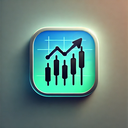

## Requirements

**Note**: Run with T4 GPU in Google Colab!

In [5]:
import os

# Store the repository URL
repo_url = 'https://github.com/gonzalopezgil/xlstm-ts.git'

# Clone the repository using HTTPS
!git clone {repo_url}

In [1]:
%cd xlstm-ts

/content/xlstm-ts


In [2]:
!pip install -r requirements.txt --quiet

NOTE: Restart session after installing the requirements

In [6]:
os.environ['TIINGO_API_KEY'] = '' # Add your Tiingo API key here

In [7]:
# Add the src directory to the Python path
import sys
sys.path.append('/content/xlstm-ts/src')

In [8]:
from ml.utils.imports import *

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


## Dataset

**S&P 500 (US)**

https://finance.yahoo.com/quote/%5EGSPC/

In [9]:
from ml.data.download import download_data, plot_data

In [10]:
start_date = "2000-01-01"

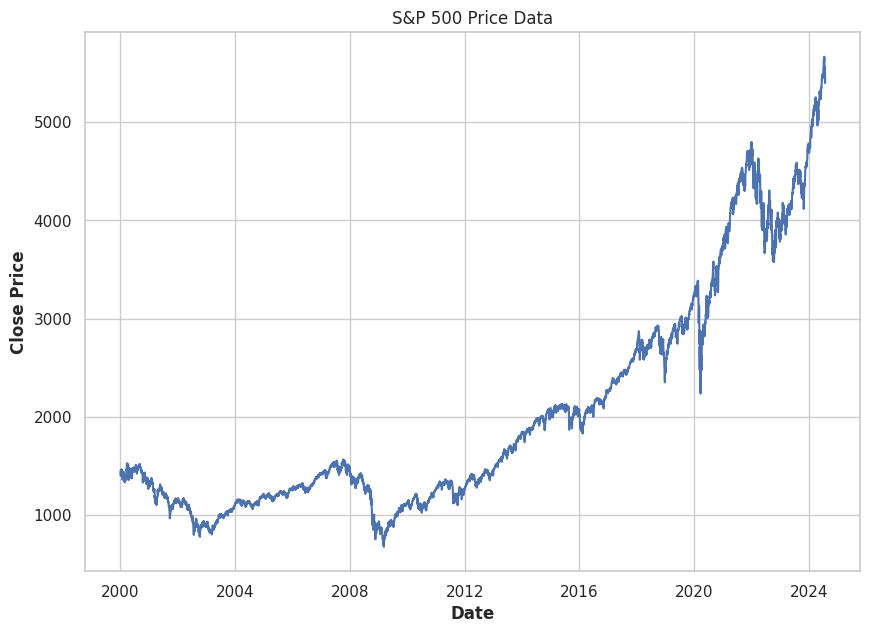

In [11]:
# Download the data
sp500_df = download_data('^GSPC', start_date, freq='daily')

stock = 'S&P 500'

# Plot the raw data
plot_data(sp500_df, stock)

## Preprocessing

### Wavelet denoising

Reference:
https://doi.org/10.1002/for.3071 (the idea of the wavelet denoising and some parameters are taken from this paper)

In [12]:
from ml.data.preprocessing import wavelet_denoising, plot_wavelet_denoising

Signal-to-Noise Ratio (SNR): 46.58 dB


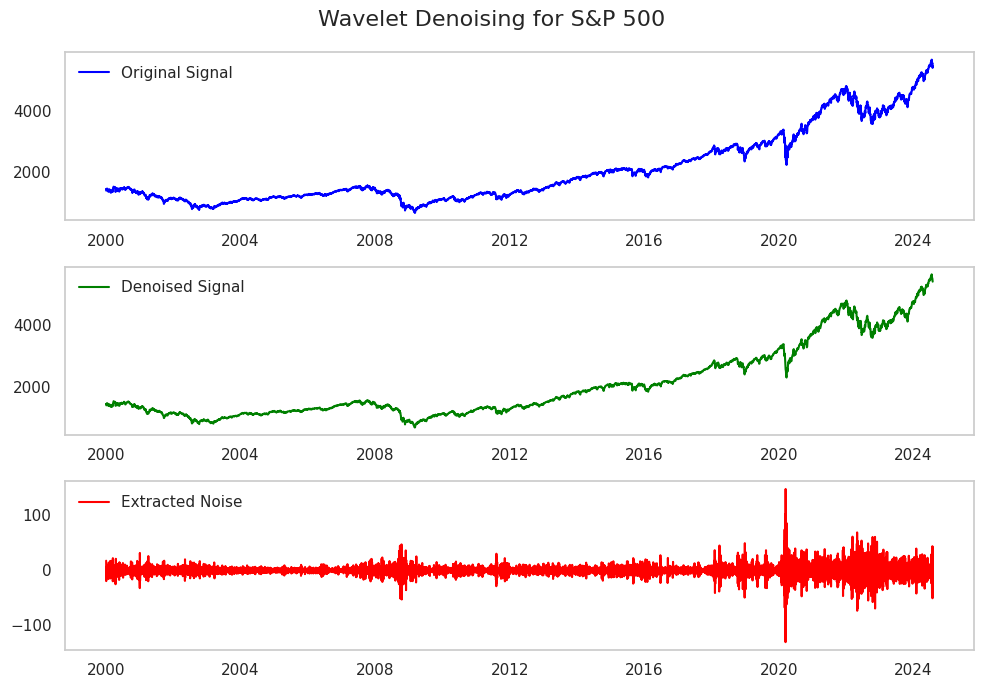

In [13]:
# Apply denoising
sp500_df['Close_denoised'] = wavelet_denoising(sp500_df['Close'])
sp500_df['Noise'] = sp500_df['Close'] - sp500_df['Close_denoised']

plot_wavelet_denoising(sp500_df, stock)

### Process dates

In [14]:
from ml.data.preprocessing import process_dates

In [15]:
# Convert the Date column to time zone-naive datetime
sp500_df = process_dates(sp500_df)

### Model-specific preprocessing

#### For darts library models

##### Convert to darts TimeSeries

**Darts Library**:

- Paper: https://www.jmlr.org/papers/v23/21-1177.html
- Documentation: https://unit8co.github.io/darts/README.html#
- Repository: https://github.com/unit8co/darts

In [16]:
from ml.darts.preprocessing import convert_to_ts_daily

In [17]:
sp500_series, sp500_series_denoised = convert_to_ts_daily(sp500_df)
sp500_series_denoised

<TimeSeries (DataArray) (Date: 6180, component: 1, sample: 1)> Size: 49kB
array([[[1437.6764069 ]],

       [[1419.02923629]],

       [[1395.54938238]],

       ...,

       [[5478.03034038]],

       [[5422.99103653]],

       [[5417.40733056]]])
Coordinates:
  * Date       (Date) datetime64[ns] 49kB 2000-01-03 2000-01-04 ... 2024-07-26
  * component  (component) <U1 4B '0'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

##### Train, Validation and Test split

*   **Train**: 01/2000 - 12/2020
*   **Validation**: 01/2021 - 06/2022
*   **Test**: 07/2022 - 12/2023



In [18]:
from ml.darts.preprocessing import split_train_val_test_darts

In [19]:
# Split the data by date
train_end_date = datetime.datetime(2021, 1, 1)
val_end_date = datetime.datetime(2022, 7, 1)

In [20]:
train, val, test = split_train_val_test_darts(sp500_series, train_end_date, val_end_date)
train_denoised, val_denoised, test_denoised = split_train_val_test_darts(sp500_series_denoised, train_end_date, val_end_date)

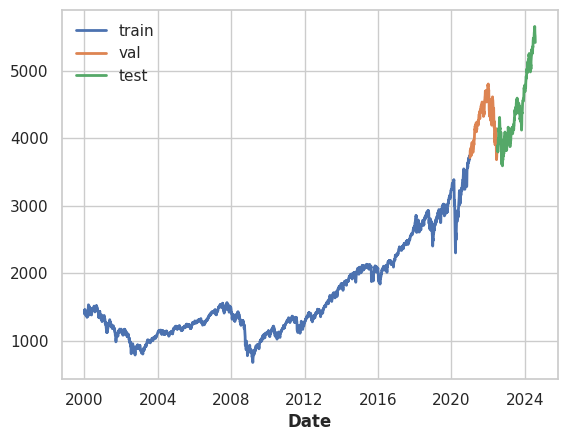

In [21]:
train_denoised.plot(label="train");
val_denoised.plot(label="val");
test_denoised.plot(label="test");

##### Normalise data

In [22]:
from ml.darts.preprocessing import normalise_split_data_darts

In [23]:
train, val, test, scaler_darts = normalise_split_data_darts(train, val, test)
train_denoised, val_denoised, test_denoised, scaler_darts_denoised = normalise_split_data_darts(train_denoised, val_denoised, test_denoised)

#### For the proposed model

##### Normalise data

In [24]:
from ml.xlstm_ts.preprocessing import normalise_data_xlstm

In [25]:
sp500_close_scaled, scaler = normalise_data_xlstm(sp500_df['Close'].values)

In [26]:
sp500_close_scaled_denoised, scaler_denoised = normalise_data_xlstm(sp500_df['Close_denoised'].values)

##### Create sequences

In [27]:
from ml.xlstm_ts.preprocessing import create_sequences

In [28]:
X, y, dates = create_sequences(sp500_close_scaled, sp500_df.index)

In [29]:
X_denoised, y_denoised, _ = create_sequences(sp500_close_scaled_denoised, sp500_df.index)

##### Train, Validation and Test split

*   **Train**: 01/2000 - 12/2020
*   **Validation**: 01/2021 - 06/2022
*   **Test**: 07/2022 - 12/2023



In [30]:
from ml.xlstm_ts.preprocessing import split_train_val_test_xlstm

train X shape: torch.Size([5134, 150, 1])
train y shape: torch.Size([5134, 1])
val X shape: torch.Size([376, 150, 1])
val y shape: torch.Size([376, 1])
test X shape: torch.Size([520, 150, 1])
test y shape: torch.Size([520, 1])


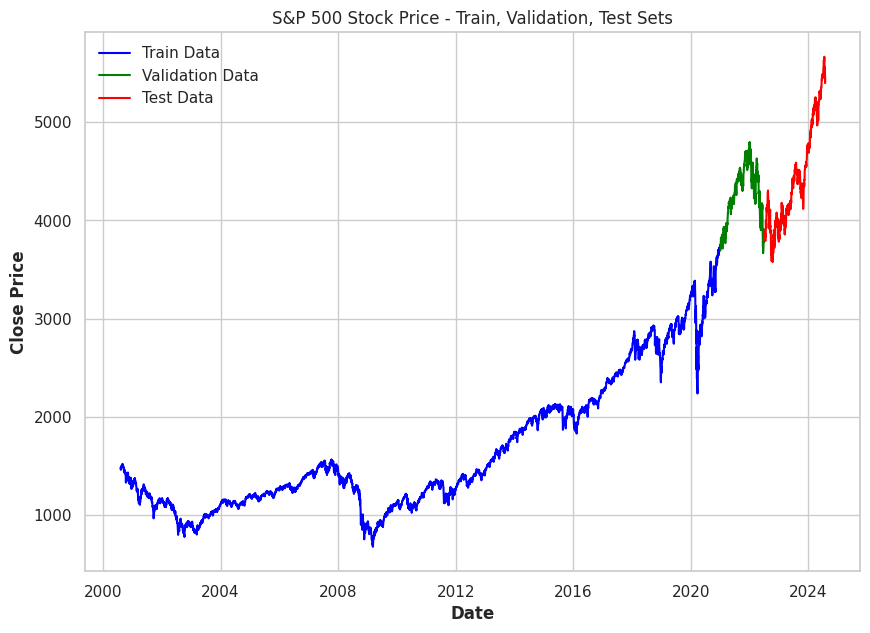

In [31]:
train_X, train_y, train_dates, val_X, val_y, val_dates, test_X, test_y, test_dates = split_train_val_test_xlstm(X, y, dates, train_end_date, val_end_date, scaler, stock)

train X shape: torch.Size([5134, 150, 1])
train y shape: torch.Size([5134, 1])
val X shape: torch.Size([376, 150, 1])
val y shape: torch.Size([376, 1])
test X shape: torch.Size([520, 150, 1])
test y shape: torch.Size([520, 1])


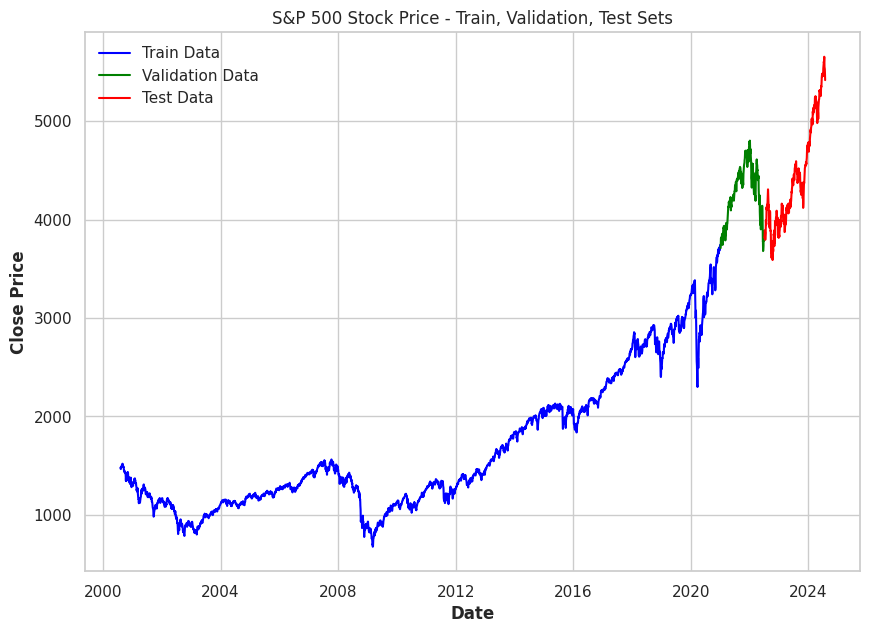

In [32]:
train_X_denoised, train_y_denoised, _, val_X_denoised, val_y_denoised, _, test_X_denoised, test_y_denoised, _ = split_train_val_test_xlstm(X_denoised, y_denoised, dates, train_end_date, val_end_date, scaler_denoised, stock)

## Models

In [33]:
from ml.models.models import *
from ml.darts.models import *

In [34]:
metrics_accumulator = {}
metrics_accumulator_denoised = {}

### TCN

**References**:

- Paper (2018): https://doi.org/10.48550/arXiv.1803.01271
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tcn_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/05-TCN-examples.html

**Not denoised**

Price Prediction Metrics:

TCN (Original) | MAE: 29.01
TCN (Original) | MSE: 1360.17
TCN (Original) | RMSE: 36.88
TCN (Original) | RMSSE: 1.01
TCN (Original) | MAPE: 0.65%
TCN (Original) | MASE: 1.02
TCN (Original) | R2: 0.99


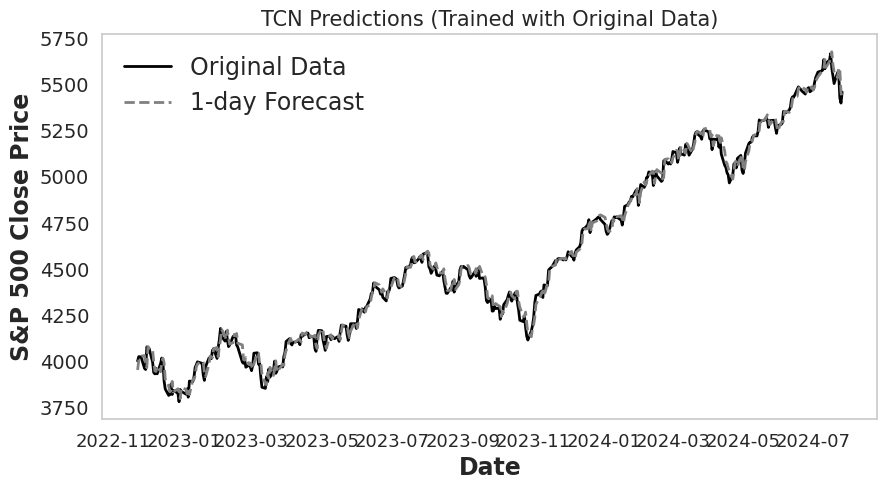

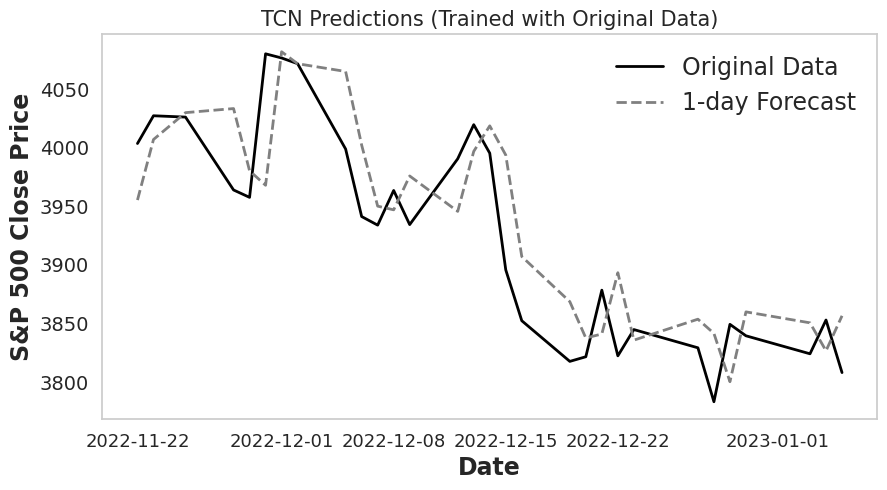


Directional Movement Metrics:

TCN (Original) | Train Accuracy: 47.83%
TCN (Original) | Validation Accuracy: 49.09%
TCN (Original) | Test Accuracy: 50.84%
TCN (Original) | Recall: 55.51%
TCN (Original) | Precision (Rise): 54.55%
TCN (Original) | Precision (Fall): 46.28%
TCN (Original) | F1 Score: 55.02%


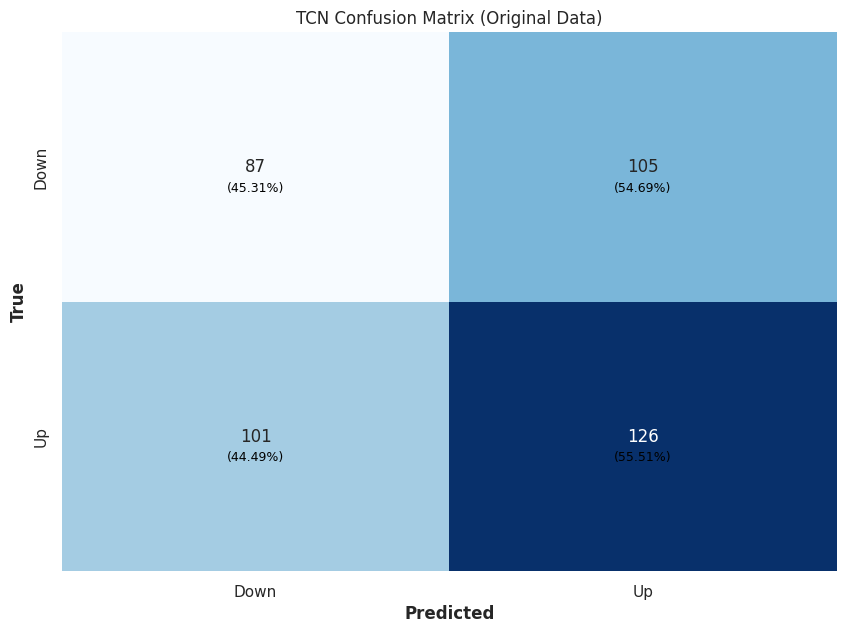

In [35]:
model = get_model_tcn()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Original")

**Denoised**

Price Prediction Metrics:

TCN (Denoised) | MAE: 33.17
TCN (Denoised) | MSE: 1587.29
TCN (Denoised) | RMSE: 39.84
TCN (Denoised) | RMSSE: 1.09
TCN (Denoised) | MAPE: 0.72%
TCN (Denoised) | MASE: 1.17
TCN (Denoised) | R2: 0.99


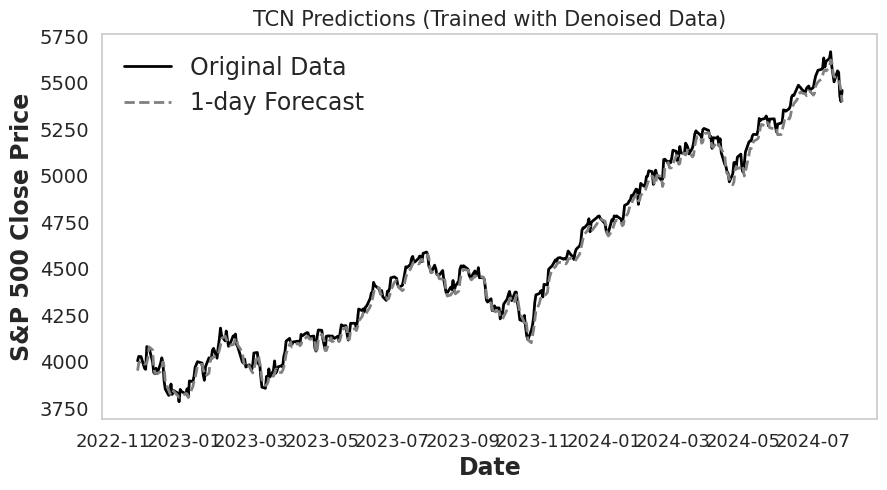

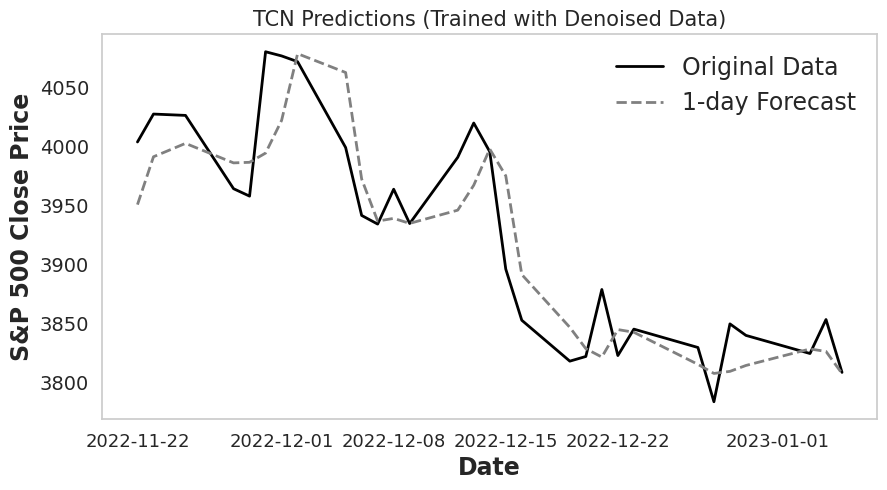


Directional Movement Metrics:

TCN (Denoised) | Train Accuracy: 64.23%
TCN (Denoised) | Validation Accuracy: 65.82%
TCN (Denoised) | Test Accuracy: 64.20%
TCN (Denoised) | Recall: 70.48%
TCN (Denoised) | Precision (Rise): 65.84%
TCN (Denoised) | Precision (Fall): 61.93%
TCN (Denoised) | F1 Score: 68.09%


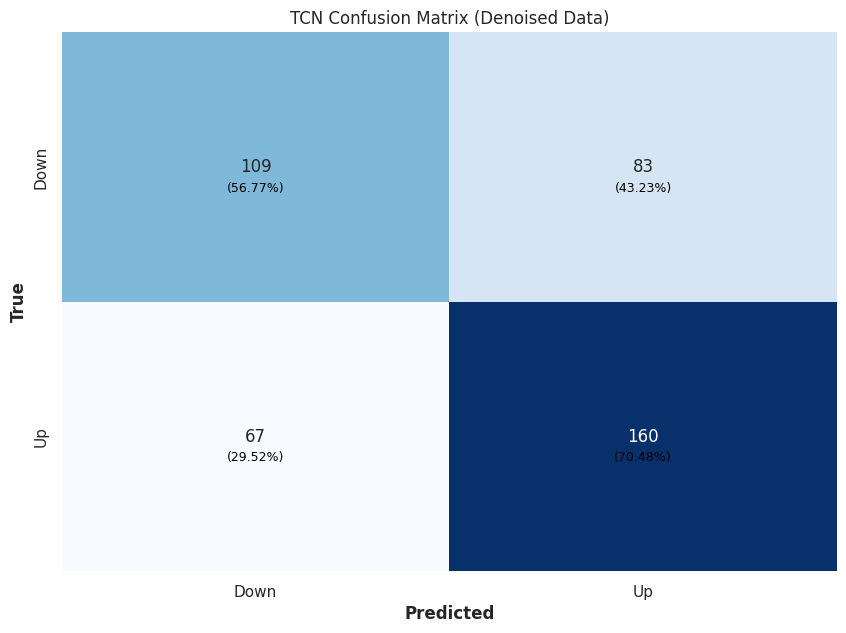

In [36]:
model = get_model_tcn()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### DeepTCN

**References**:

- Paper (2020): https://doi.org/10.48550/arXiv.1906.04397
- Code (same as TCN): https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tcn_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/09-DeepTCN-examples.html

**Not denoised**

Price Prediction Metrics:

DeepTCN (Original) | MAE: 59.08
DeepTCN (Original) | MSE: 4761.12
DeepTCN (Original) | RMSE: 69.00
DeepTCN (Original) | RMSSE: 1.89
DeepTCN (Original) | MAPE: 1.28%
DeepTCN (Original) | MASE: 2.08
DeepTCN (Original) | R2: 0.98


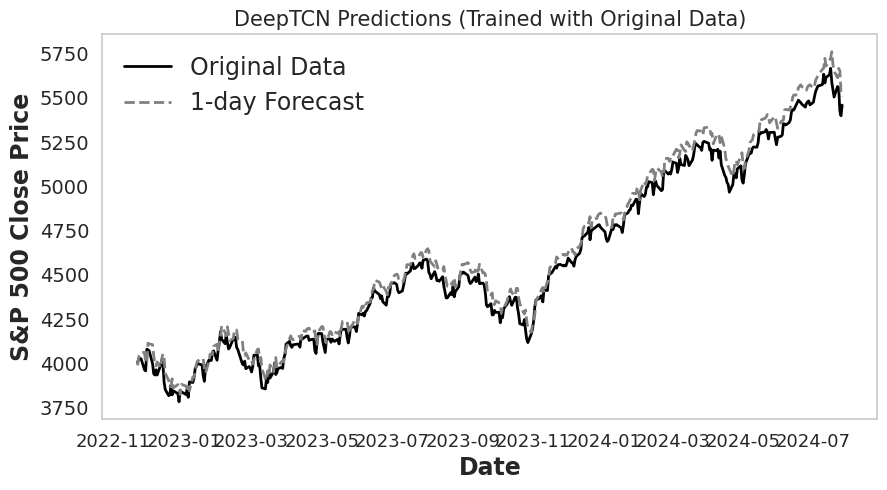

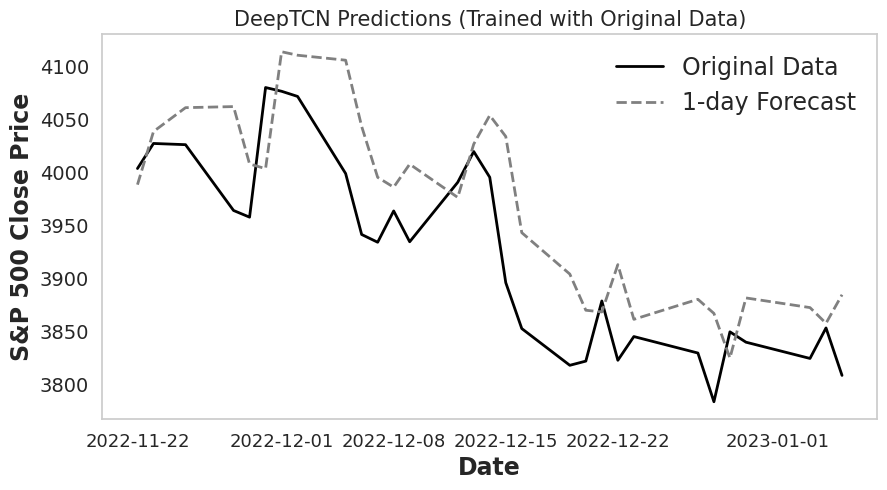


Directional Movement Metrics:

DeepTCN (Original) | Train Accuracy: 47.06%
DeepTCN (Original) | Validation Accuracy: 50.55%
DeepTCN (Original) | Test Accuracy: 50.84%
DeepTCN (Original) | Recall: 55.07%
DeepTCN (Original) | Precision (Rise): 54.59%
DeepTCN (Original) | Precision (Fall): 46.32%
DeepTCN (Original) | F1 Score: 54.82%


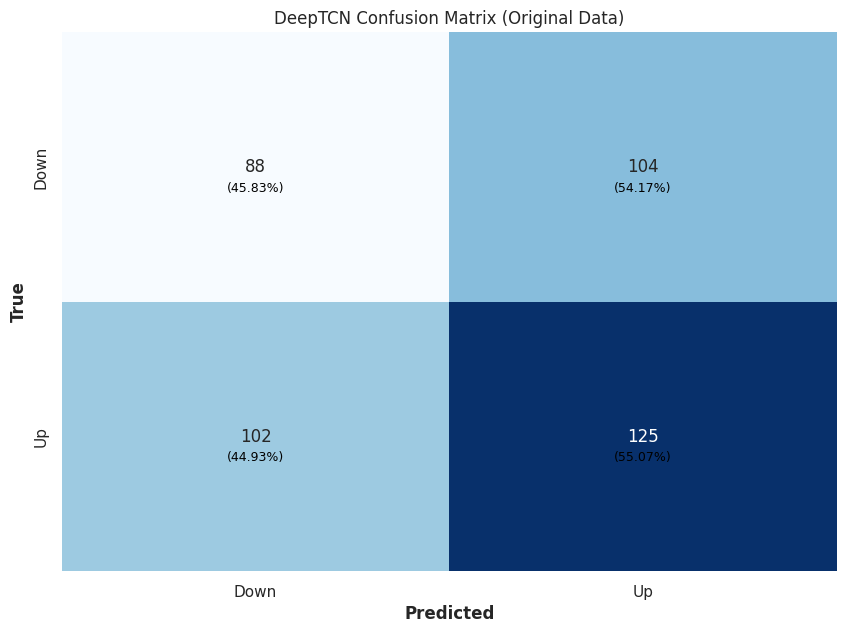

In [37]:
model = get_model_deeptcn()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Original")

**Denoised**

Price Prediction Metrics:

DeepTCN (Denoised) | MAE: 65.56
DeepTCN (Denoised) | MSE: 5503.36
DeepTCN (Denoised) | RMSE: 74.18
DeepTCN (Denoised) | RMSSE: 2.04
DeepTCN (Denoised) | MAPE: 1.42%
DeepTCN (Denoised) | MASE: 2.31
DeepTCN (Denoised) | R2: 0.98


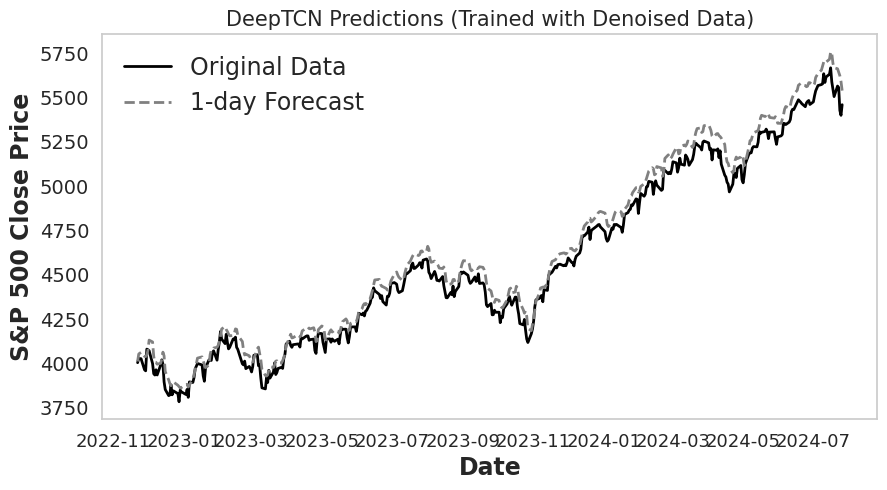

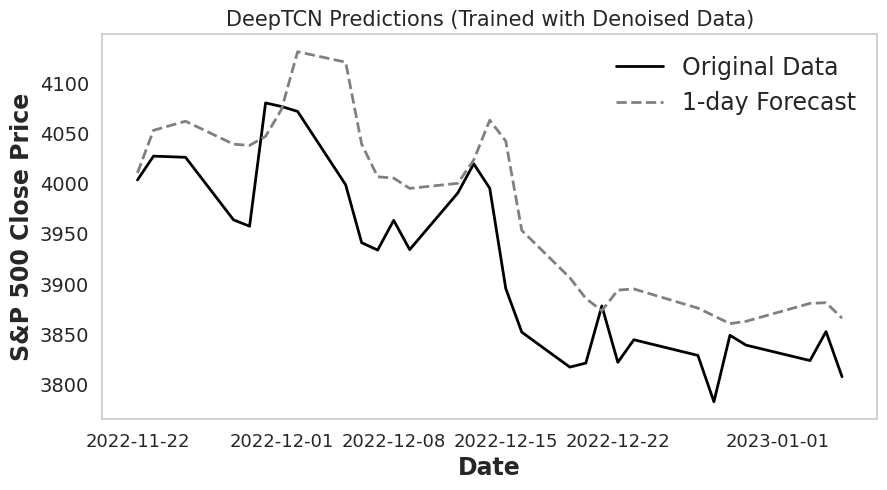


Directional Movement Metrics:

DeepTCN (Denoised) | Train Accuracy: 64.65%
DeepTCN (Denoised) | Validation Accuracy: 65.45%
DeepTCN (Denoised) | Test Accuracy: 62.77%
DeepTCN (Denoised) | Recall: 70.93%
DeepTCN (Denoised) | Precision (Rise): 64.14%
DeepTCN (Denoised) | Precision (Fall): 60.71%
DeepTCN (Denoised) | F1 Score: 67.36%


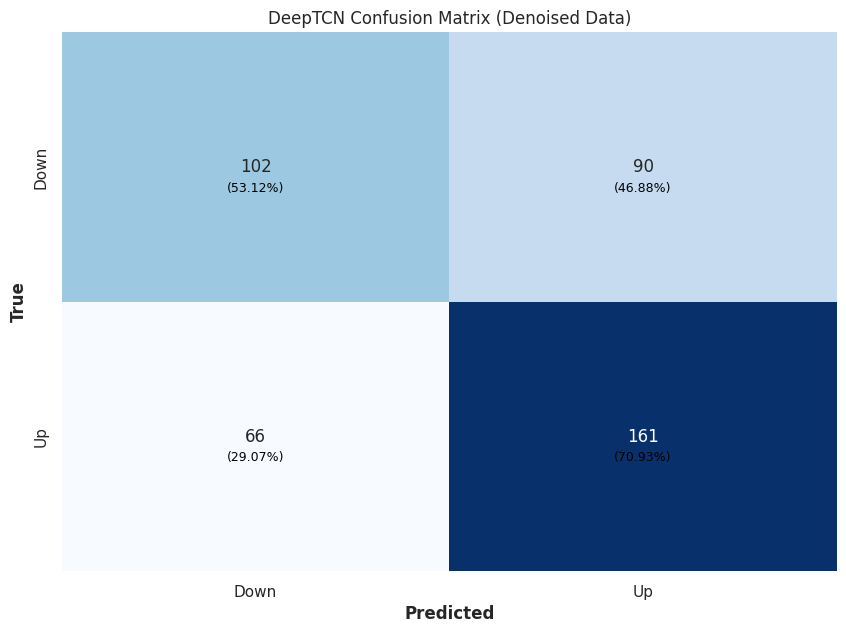

In [38]:
model = get_model_deeptcn()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### N-BEATS

**References**:
- Paper (2020): https://doi.org/10.48550/arXiv.1905.10437
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/nbeats.py
- Darts documentation: https://unit8co.github.io/darts/examples/07-NBEATS-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-BEATS (Original) | MAE: 52.46
N-BEATS (Original) | MSE: 4621.72
N-BEATS (Original) | RMSE: 67.98
N-BEATS (Original) | RMSSE: 1.87
N-BEATS (Original) | MAPE: 1.16%
N-BEATS (Original) | MASE: 1.85
N-BEATS (Original) | R2: 0.98


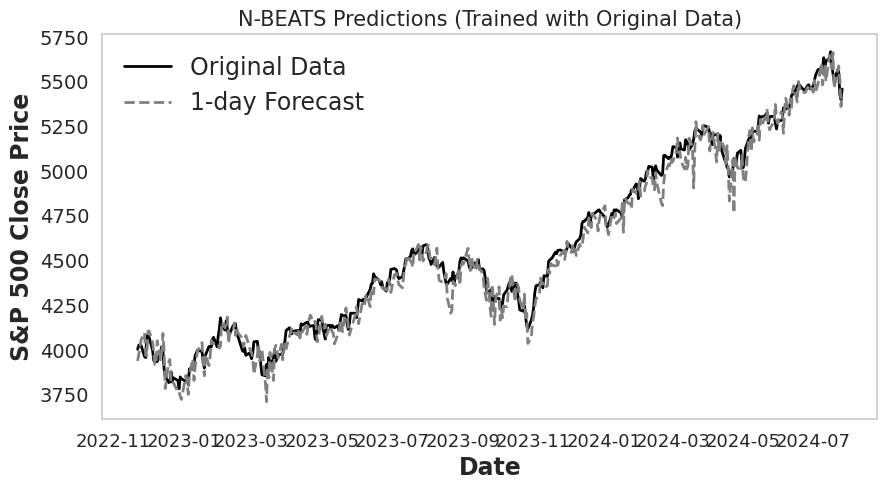

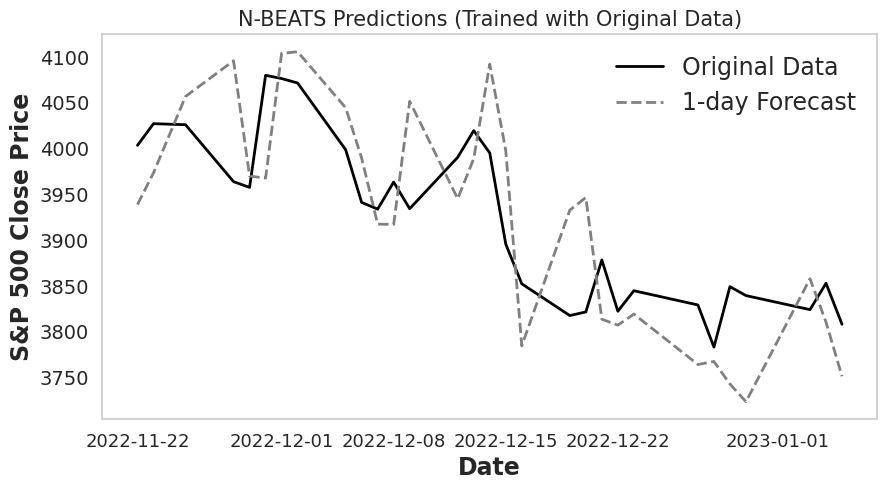


Directional Movement Metrics:

N-BEATS (Original) | Train Accuracy: 50.03%
N-BEATS (Original) | Validation Accuracy: 57.82%
N-BEATS (Original) | Test Accuracy: 48.69%
N-BEATS (Original) | Recall: 49.34%
N-BEATS (Original) | Precision (Rise): 52.83%
N-BEATS (Original) | Precision (Fall): 44.44%
N-BEATS (Original) | F1 Score: 51.03%


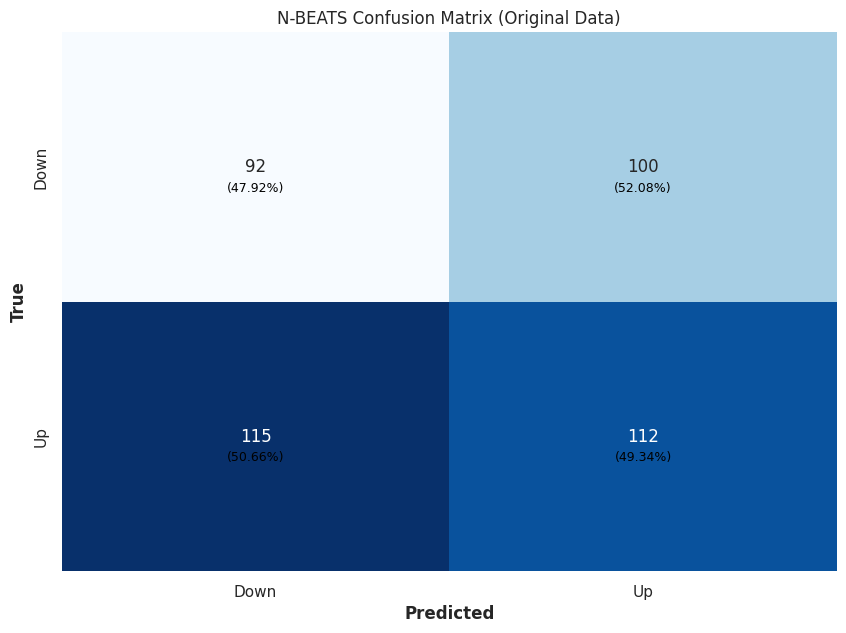

In [39]:
model = get_model_nbeats()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-BEATS (Denoised) | MAE: 32.70
N-BEATS (Denoised) | MSE: 1886.04
N-BEATS (Denoised) | RMSE: 43.43
N-BEATS (Denoised) | RMSSE: 1.19
N-BEATS (Denoised) | MAPE: 0.73%
N-BEATS (Denoised) | MASE: 1.15
N-BEATS (Denoised) | R2: 0.99


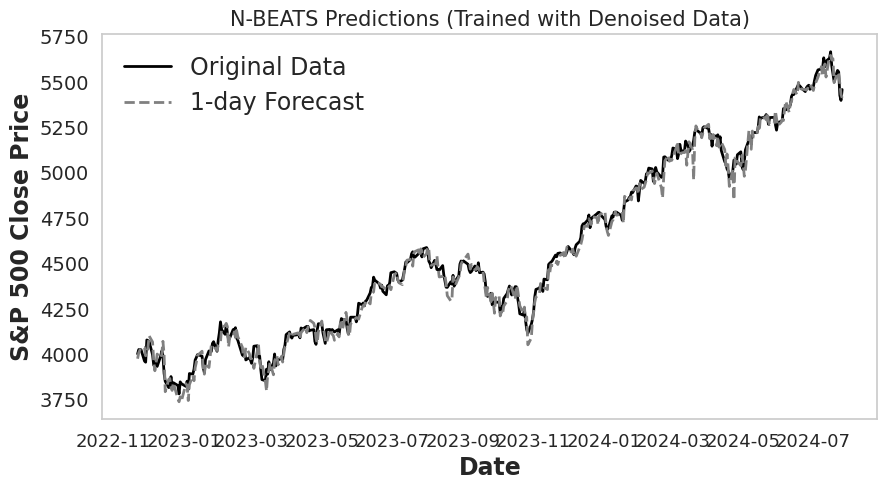

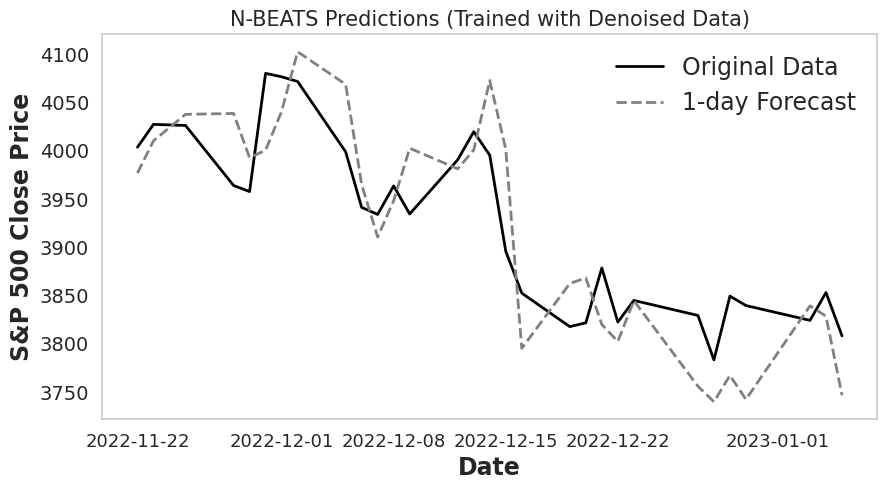


Directional Movement Metrics:

N-BEATS (Denoised) | Train Accuracy: 58.56%
N-BEATS (Denoised) | Validation Accuracy: 63.64%
N-BEATS (Denoised) | Test Accuracy: 57.76%
N-BEATS (Denoised) | Recall: 60.79%
N-BEATS (Denoised) | Precision (Rise): 61.06%
N-BEATS (Denoised) | Precision (Fall): 53.89%
N-BEATS (Denoised) | F1 Score: 60.93%


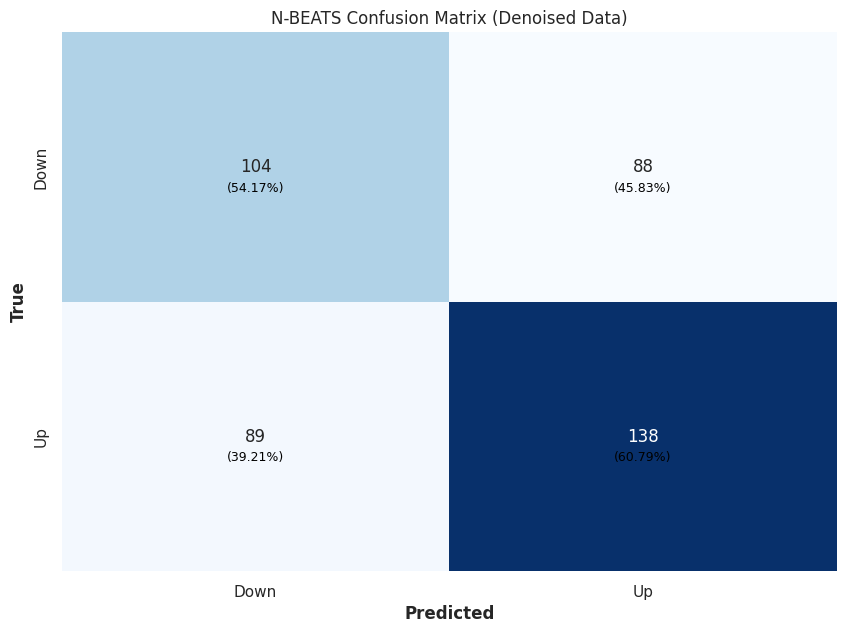

In [40]:
model = get_model_nbeats()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### TFT

Temporal Fusion Transformer Model

**References**:

- Paper (2021): https://doi.org/10.1016/j.ijforecast.2021.03.012
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tft_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/13-TFT-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TFT (Original) | MAE: 55.93
TFT (Original) | MSE: 6182.68
TFT (Original) | RMSE: 78.63
TFT (Original) | RMSSE: 2.16
TFT (Original) | MAPE: 1.24%
TFT (Original) | MASE: 1.97
TFT (Original) | R2: 0.98


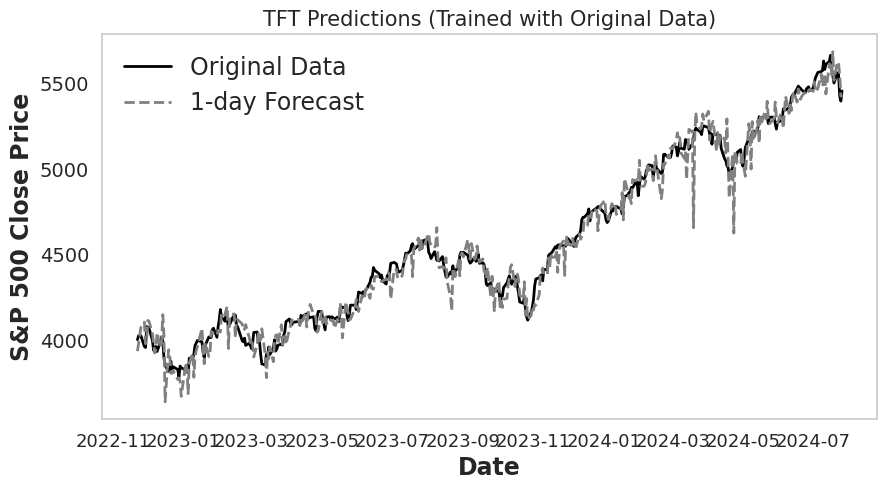

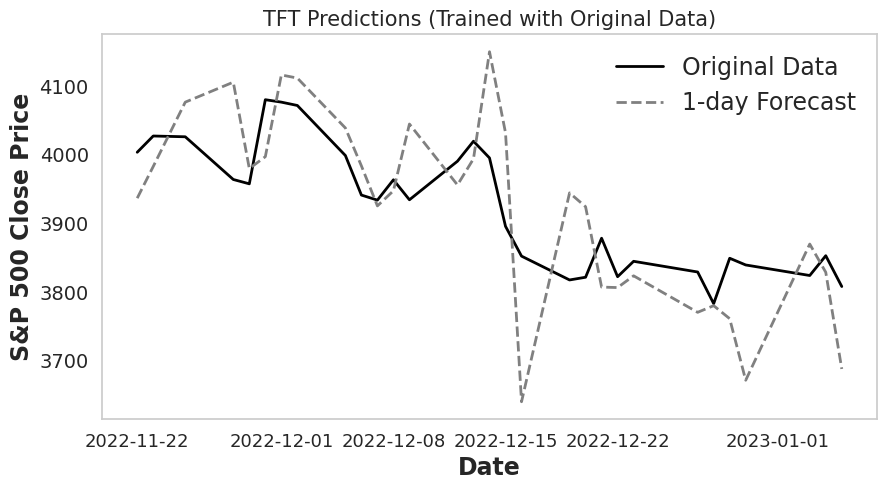


Directional Movement Metrics:

TFT (Original) | Train Accuracy: 48.31%
TFT (Original) | Validation Accuracy: 59.27%
TFT (Original) | Test Accuracy: 50.12%
TFT (Original) | Recall: 51.10%
TFT (Original) | Precision (Rise): 54.21%
TFT (Original) | Precision (Fall): 45.85%
TFT (Original) | F1 Score: 52.61%


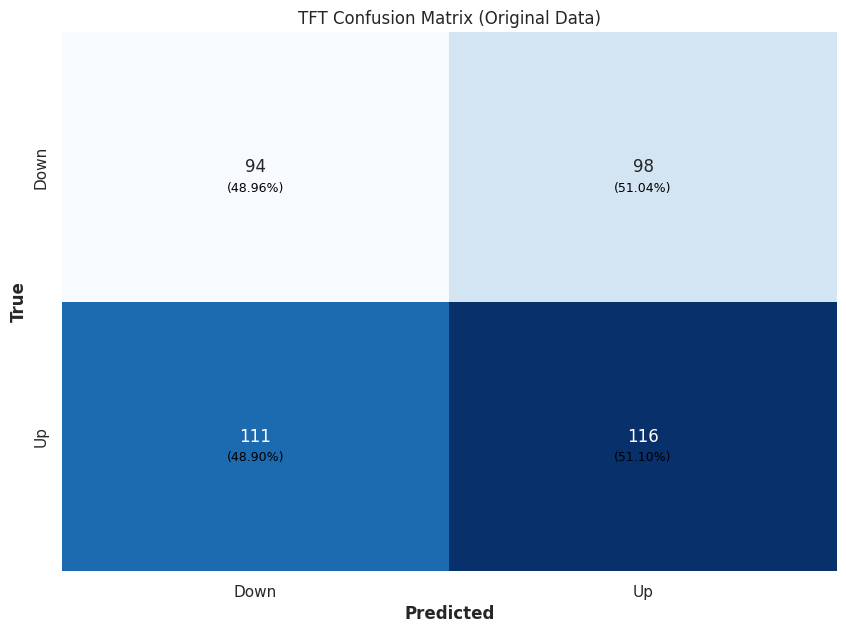

In [41]:
model = get_model_tft()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TFT (Denoised) | MAE: 52.00
TFT (Denoised) | MSE: 5437.44
TFT (Denoised) | RMSE: 73.74
TFT (Denoised) | RMSSE: 2.02
TFT (Denoised) | MAPE: 1.15%
TFT (Denoised) | MASE: 1.83
TFT (Denoised) | R2: 0.98


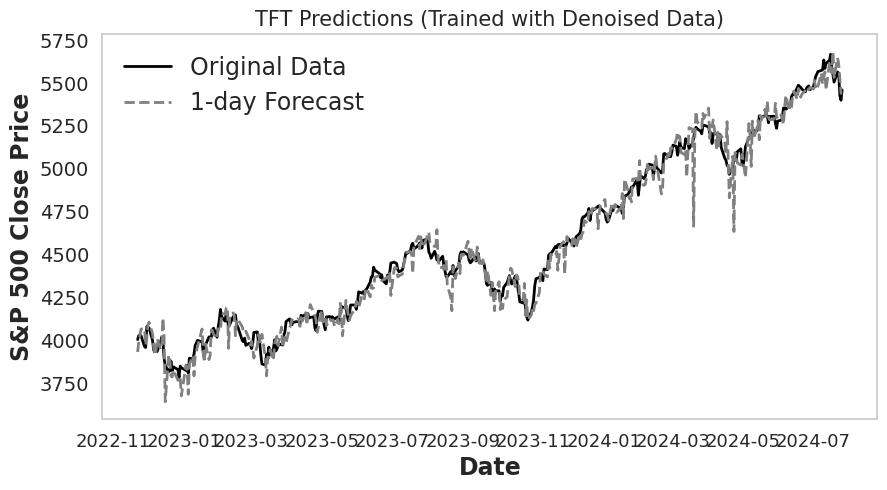

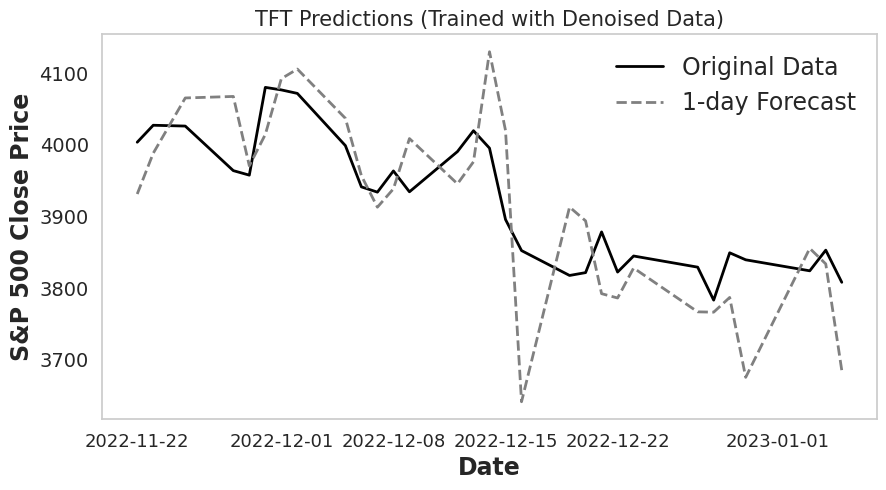


Directional Movement Metrics:

TFT (Denoised) | Train Accuracy: 51.90%
TFT (Denoised) | Validation Accuracy: 60.36%
TFT (Denoised) | Test Accuracy: 54.42%
TFT (Denoised) | Recall: 55.07%
TFT (Denoised) | Precision (Rise): 58.41%
TFT (Denoised) | Precision (Fall): 50.24%
TFT (Denoised) | F1 Score: 56.69%


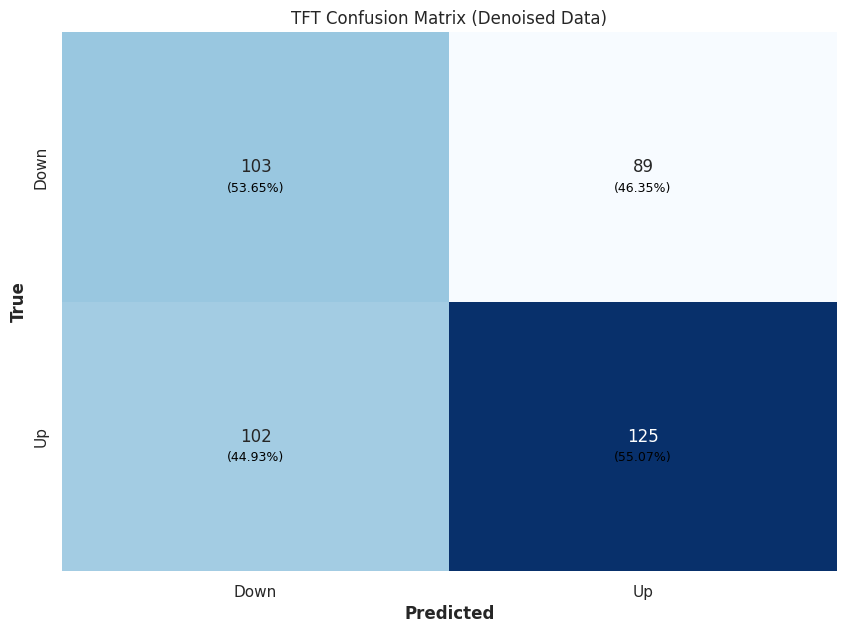

In [42]:
model = get_model_tft()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### TiDE

TimeSeries Dense Encoder Model

**References**:
- Paper (2024): https://doi.org/10.48550/arXiv.2304.08424
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/tide_model.py
- Darts documentation: https://unit8co.github.io/darts/examples/18-TiDE-examples.html

**+RIN**

Reversible Instance Normalization for Accurate Time-Series Forecasting against Distribution Shift

- Paper: https://openreview.net/forum?id=cGDAkQo1C0p

**Not denoised**

Price Prediction Metrics:

TiDE (Original) | MAE: 30.91
TiDE (Original) | MSE: 1516.80
TiDE (Original) | RMSE: 38.95
TiDE (Original) | RMSSE: 1.07
TiDE (Original) | MAPE: 0.69%
TiDE (Original) | MASE: 1.09
TiDE (Original) | R2: 0.99


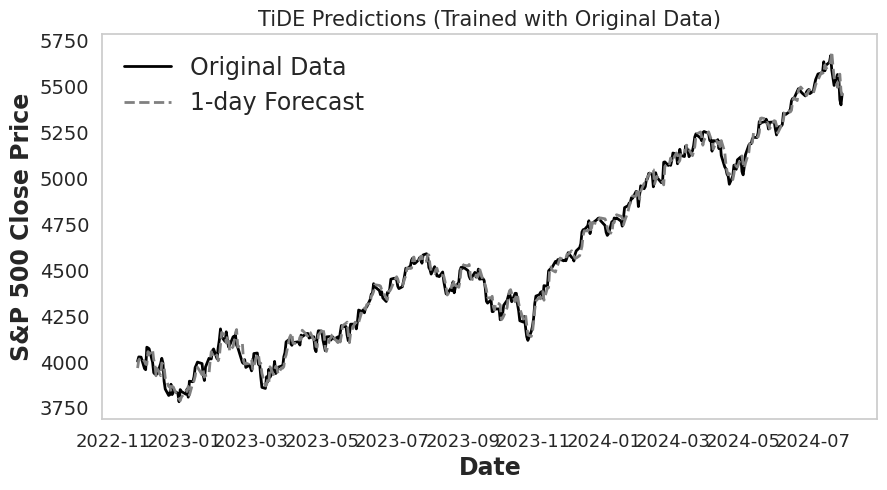

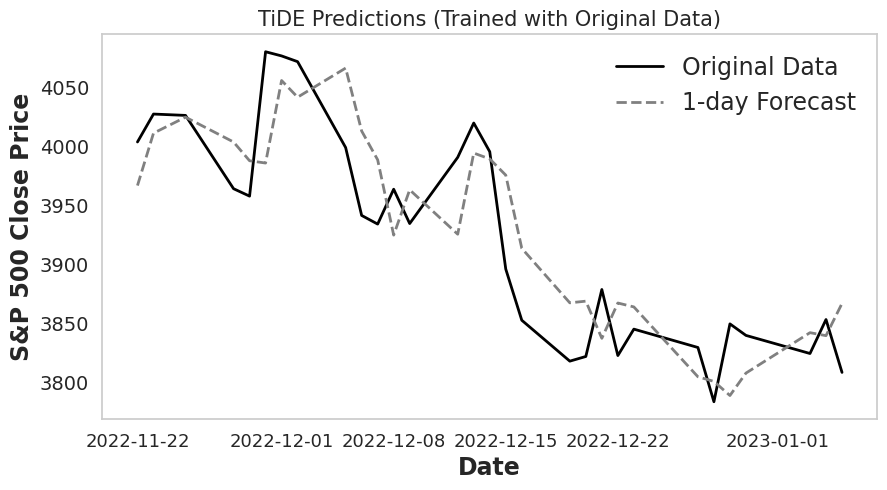


Directional Movement Metrics:

TiDE (Original) | Train Accuracy: 53.39%
TiDE (Original) | Validation Accuracy: 53.82%
TiDE (Original) | Test Accuracy: 50.84%
TiDE (Original) | Recall: 54.63%
TiDE (Original) | Precision (Rise): 54.63%
TiDE (Original) | Precision (Fall): 46.35%
TiDE (Original) | F1 Score: 54.63%


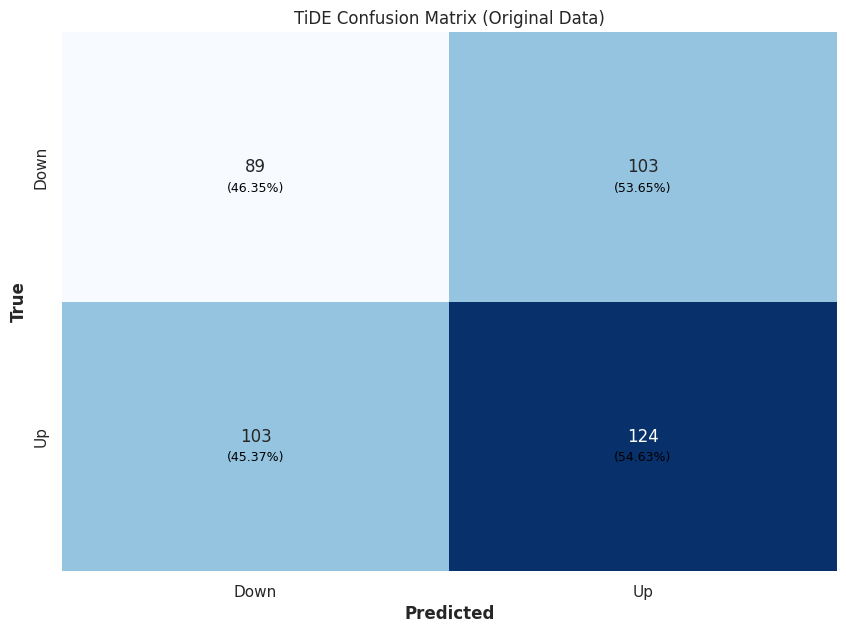

In [43]:
model = get_model_tide()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Original")

**Denoised**

Price Prediction Metrics:

TiDE (Denoised) | MAE: 24.01
TiDE (Denoised) | MSE: 921.82
TiDE (Denoised) | RMSE: 30.36
TiDE (Denoised) | RMSSE: 0.83
TiDE (Denoised) | MAPE: 0.53%
TiDE (Denoised) | MASE: 0.85
TiDE (Denoised) | R2: 1.00


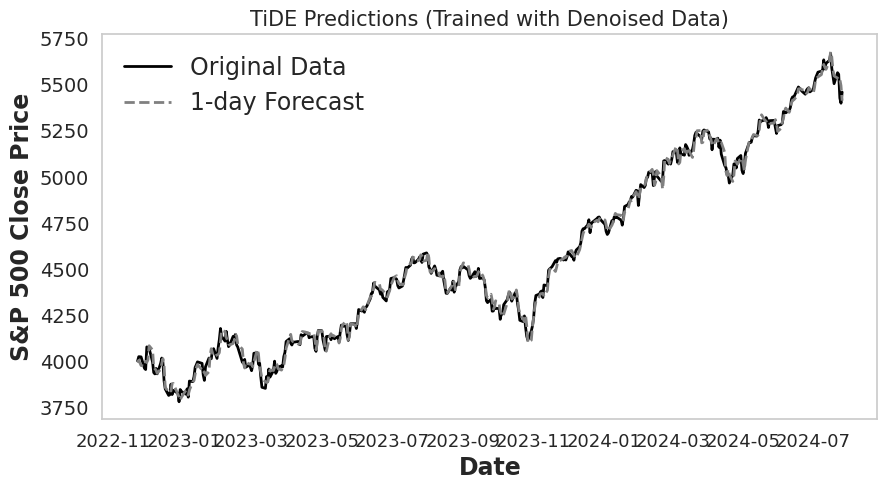

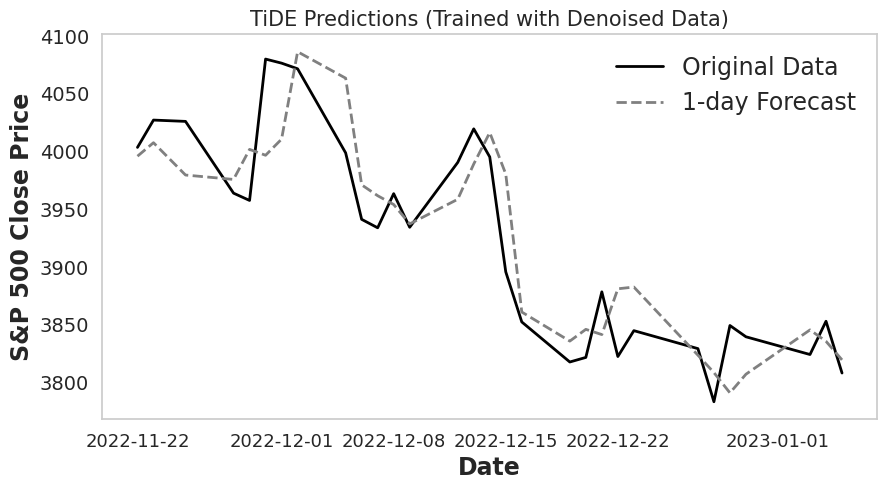


Directional Movement Metrics:

TiDE (Denoised) | Train Accuracy: 67.55%
TiDE (Denoised) | Validation Accuracy: 68.36%
TiDE (Denoised) | Test Accuracy: 64.44%
TiDE (Denoised) | Recall: 68.28%
TiDE (Denoised) | Precision (Rise): 66.81%
TiDE (Denoised) | Precision (Fall): 61.50%
TiDE (Denoised) | F1 Score: 67.54%


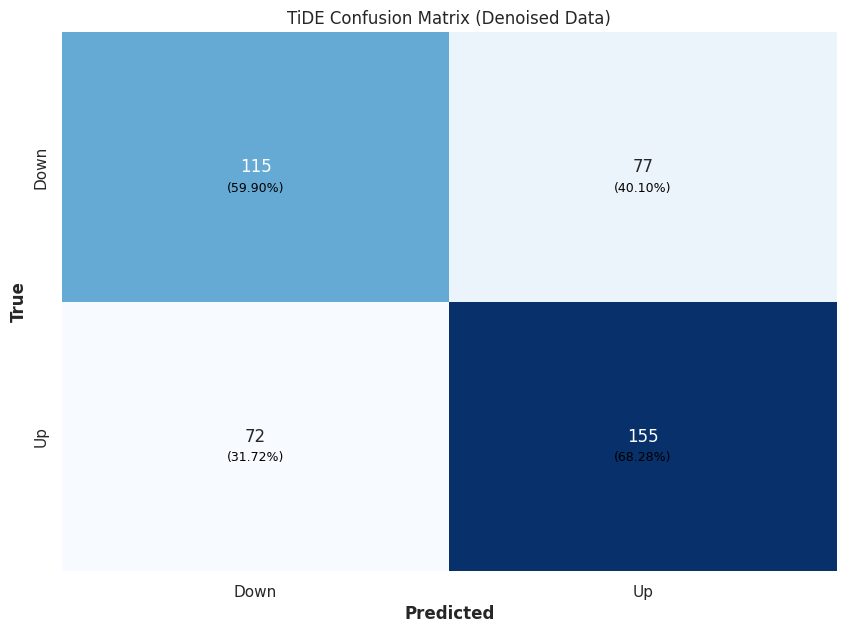

In [44]:
model = get_model_tide()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### N-HiTS

**Neural Hierarchical Interpolation for Time Series Forecasting**

References:

- Paper (2022): https://doi.org/10.48550/arXiv.2201.12886
- Code: https://github.com/unit8co/darts/blob/master/darts/models/forecasting/nhits.py
- Darts documentation: https://unit8co.github.io/darts/examples/18-TiDE-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-HiTS (Original) | MAE: 46.39
N-HiTS (Original) | MSE: 3648.80
N-HiTS (Original) | RMSE: 60.41
N-HiTS (Original) | RMSSE: 1.66
N-HiTS (Original) | MAPE: 1.03%
N-HiTS (Original) | MASE: 1.63
N-HiTS (Original) | R2: 0.99


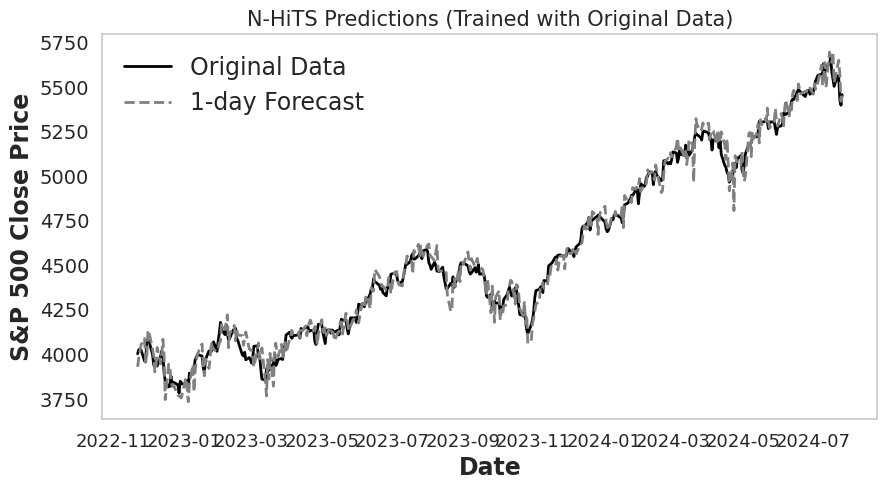

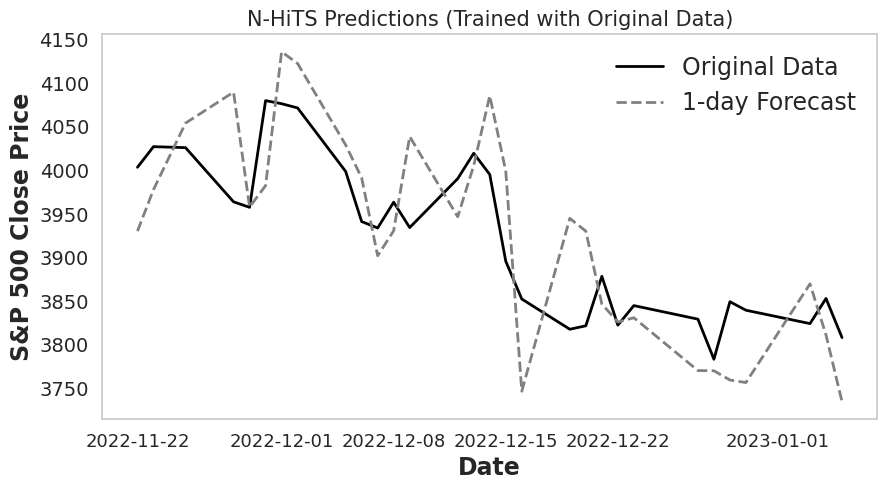


Directional Movement Metrics:

N-HiTS (Original) | Train Accuracy: 48.68%
N-HiTS (Original) | Validation Accuracy: 57.45%
N-HiTS (Original) | Test Accuracy: 49.40%
N-HiTS (Original) | Recall: 51.10%
N-HiTS (Original) | Precision (Rise): 53.46%
N-HiTS (Original) | Precision (Fall): 45.05%
N-HiTS (Original) | F1 Score: 52.25%


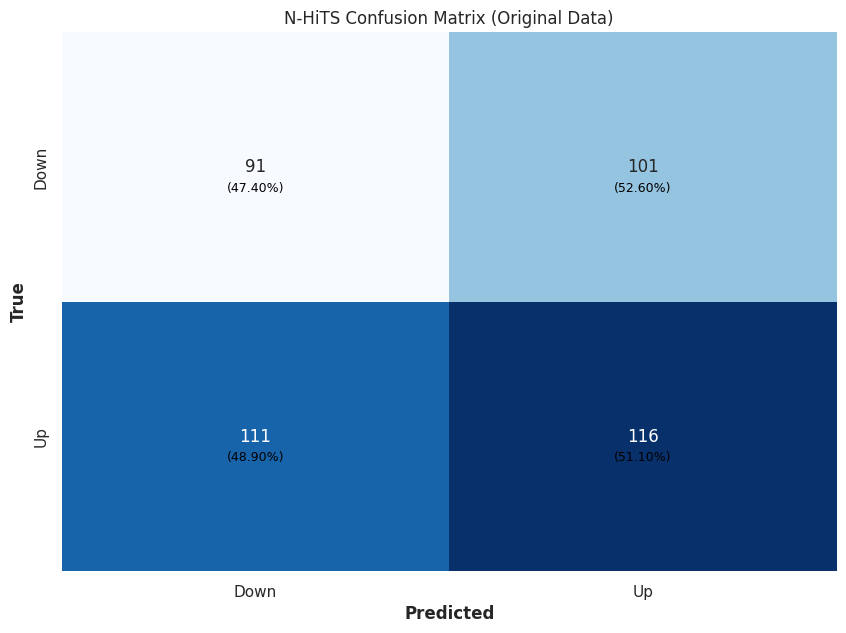

In [45]:
model = get_model_nhits()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

N-HiTS (Denoised) | MAE: 34.72
N-HiTS (Denoised) | MSE: 1999.87
N-HiTS (Denoised) | RMSE: 44.72
N-HiTS (Denoised) | RMSSE: 1.23
N-HiTS (Denoised) | MAPE: 0.77%
N-HiTS (Denoised) | MASE: 1.22
N-HiTS (Denoised) | R2: 0.99


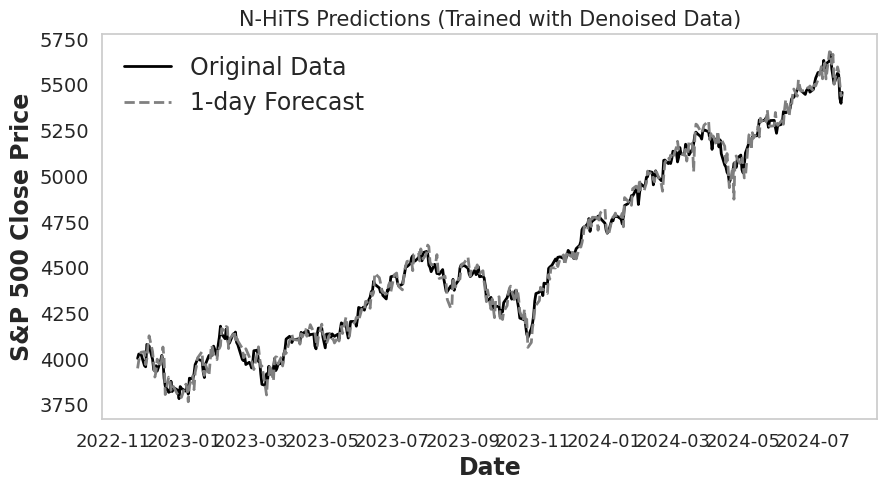

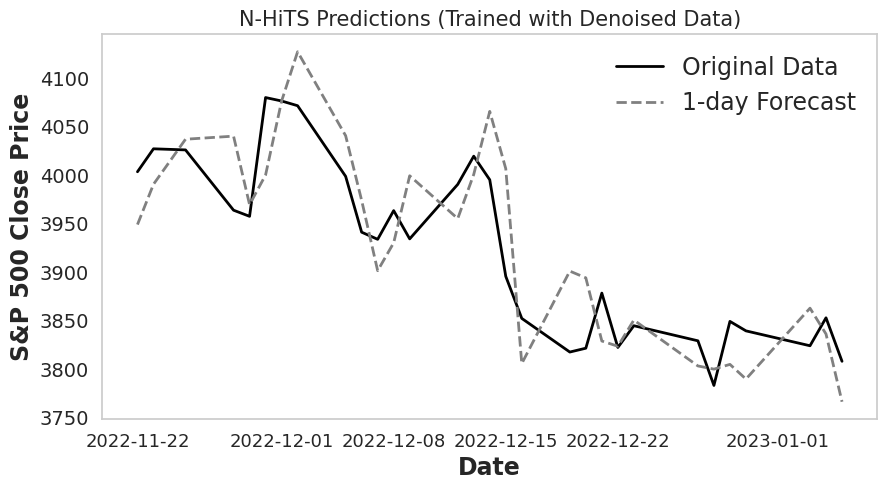


Directional Movement Metrics:

N-HiTS (Denoised) | Train Accuracy: 56.38%
N-HiTS (Denoised) | Validation Accuracy: 64.36%
N-HiTS (Denoised) | Test Accuracy: 55.37%
N-HiTS (Denoised) | Recall: 55.95%
N-HiTS (Denoised) | Precision (Rise): 59.35%
N-HiTS (Denoised) | Precision (Fall): 51.22%
N-HiTS (Denoised) | F1 Score: 57.60%


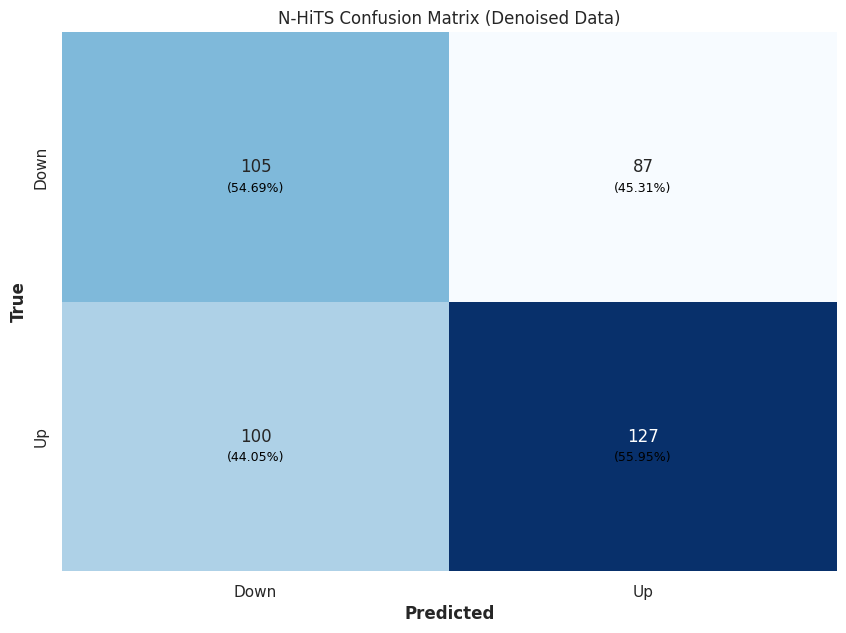

In [46]:
model = get_model_nhits()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### TSMixer

TimeSeries Mixer Model

**References**:
- Paper (2023): https://doi.org/10.48550/arXiv.2303.06053
- Code: https://github.com/ditschuk/pytorch-tsmixer
- Darts documentation: https://unit8co.github.io/darts/examples/21-TSMixer-examples.html

**Not denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TSMixer (Original) | MAE: 94.58
TSMixer (Original) | MSE: 17259.72
TSMixer (Original) | RMSE: 131.38
TSMixer (Original) | RMSSE: 3.61
TSMixer (Original) | MAPE: 2.09%
TSMixer (Original) | MASE: 3.33
TSMixer (Original) | R2: 0.93


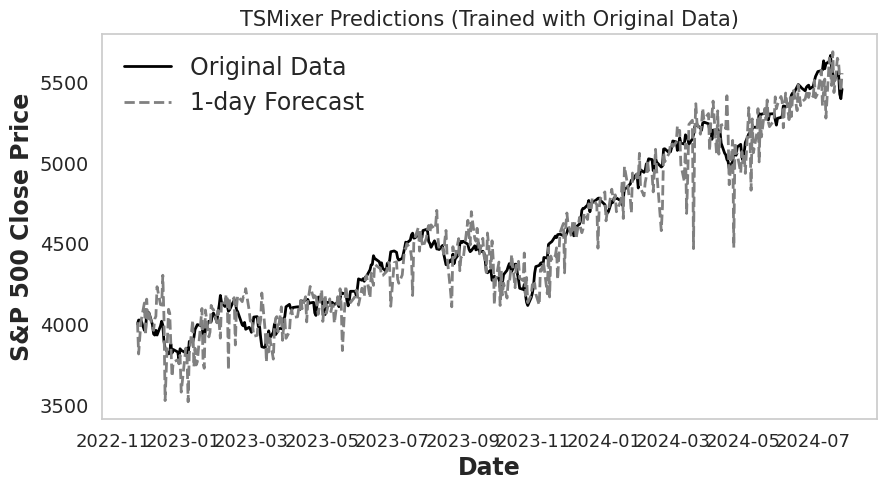

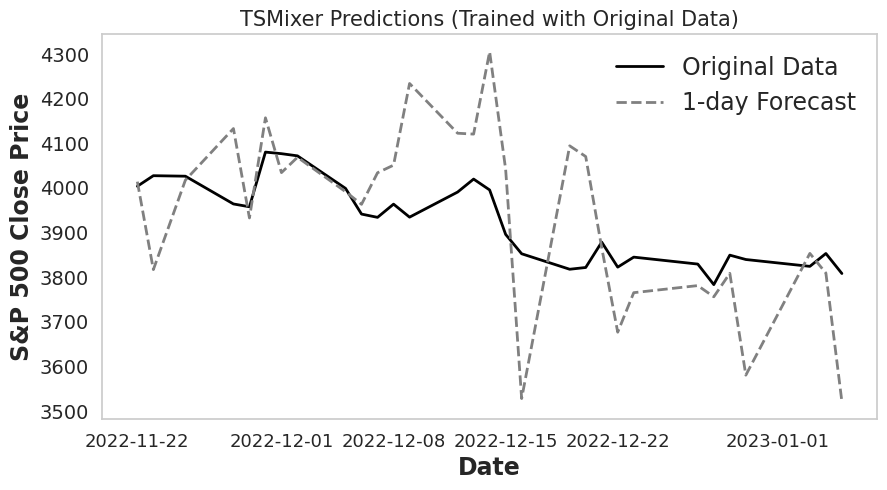


Directional Movement Metrics:

TSMixer (Original) | Train Accuracy: 48.91%
TSMixer (Original) | Validation Accuracy: 56.00%
TSMixer (Original) | Test Accuracy: 48.45%
TSMixer (Original) | Recall: 50.22%
TSMixer (Original) | Precision (Rise): 52.53%
TSMixer (Original) | Precision (Fall): 44.06%
TSMixer (Original) | F1 Score: 51.35%


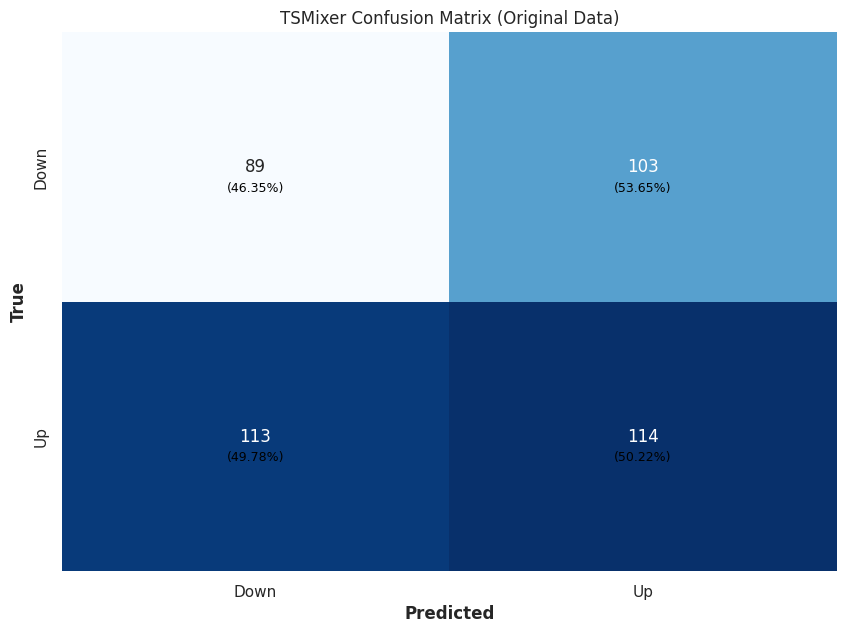

In [47]:
model = get_model_tsm()
metrics_accumulator[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Original")

**Denoised**

Training: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Price Prediction Metrics:

TSMixer (Denoised) | MAE: 88.92
TSMixer (Denoised) | MSE: 15232.42
TSMixer (Denoised) | RMSE: 123.42
TSMixer (Denoised) | RMSSE: 3.39
TSMixer (Denoised) | MAPE: 1.97%
TSMixer (Denoised) | MASE: 3.13
TSMixer (Denoised) | R2: 0.94


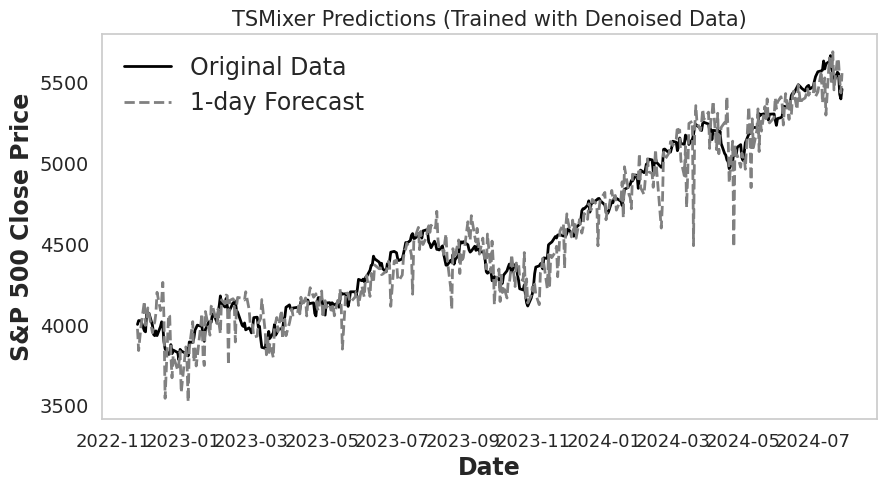

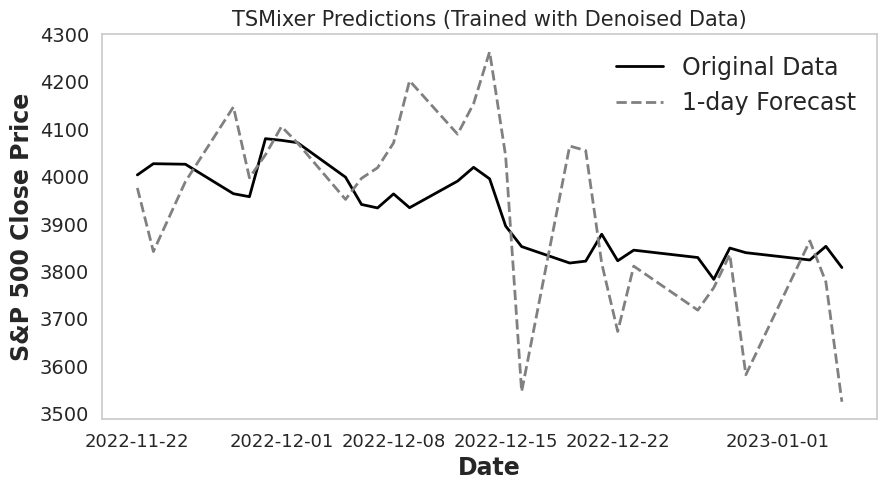


Directional Movement Metrics:

TSMixer (Denoised) | Train Accuracy: 49.80%
TSMixer (Denoised) | Validation Accuracy: 56.36%
TSMixer (Denoised) | Test Accuracy: 49.16%
TSMixer (Denoised) | Recall: 51.10%
TSMixer (Denoised) | Precision (Rise): 53.21%
TSMixer (Denoised) | Precision (Fall): 44.78%
TSMixer (Denoised) | F1 Score: 52.13%


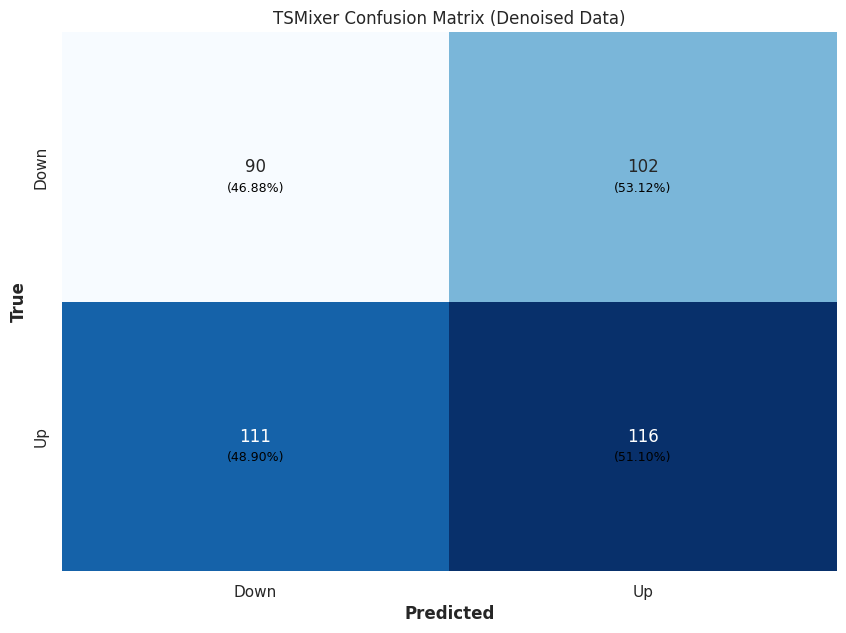

In [48]:
model = get_model_tsm()
metrics_accumulator_denoised[model.model_name] = training_darts(model, train, val, test, scaler_darts, stock, "Denoised", train_denoised, val_denoised, test_denoised, scaler_darts_denoised)

### New proposed model: xLSTM-TS, a time series-specific implementation

**References:**

- Paper (2024): https://doi.org/10.48550/arXiv.2405.04517

- Official code: https://github.com/NX-AI/xlstm

- Parameters for time series: https://github.com/smvorwerk/xlstm-cuda

#### Configuration

In [49]:
from ml.xlstm_ts.model import *

In [50]:
plot_architecture_xlstm()

{'verbose': True, 'with_cuda': True, 'extra_ldflags': ['-L/usr/local/cuda/lib', '-lcublas'], 'extra_cflags': ['-DSLSTM_HIDDEN_SIZE=64', '-DSLSTM_BATCH_SIZE=8', '-DSLSTM_NUM_HEADS=2', '-DSLSTM_NUM_STATES=4', '-DSLSTM_DTYPE_B=float', '-DSLSTM_DTYPE_R=__nv_bfloat16', '-DSLSTM_DTYPE_W=__nv_bfloat16', '-DSLSTM_DTYPE_G=__nv_bfloat16', '-DSLSTM_DTYPE_S=__nv_bfloat16', '-DSLSTM_DTYPE_A=float', '-DSLSTM_NUM_GATES=4', '-DSLSTM_SIMPLE_AGG=true', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL_VALID=false', '-DSLSTM_GRADIENT_RECURRENT_CLIPVAL=0.0', '-DSLSTM_FORWARD_CLIPVAL_VALID=false', '-DSLSTM_FORWARD_CLIPVAL=0.0', '-U__CUDA_NO_HALF_OPERATORS__', '-U__CUDA_NO_HALF_CONVERSIONS__', '-U__CUDA_NO_BFLOAT16_OPERATORS__', '-U__CUDA_NO_BFLOAT16_CONVERSIONS__', '-U__CUDA_NO_BFLOAT162_OPERATORS__', '-U__CUDA_NO_BFLOAT162_CONVERSIONS__'], 'extra_cuda_cflags': ['-Xptxas="-v"', '-gencode', 'arch=compute_80,code=compute_80', '-res-usage', '--use_fast_math', '-O3', '-Xptxas -O3', '--extra-device-vectorization', '-DSLSTM_H

Using /root/.cache/torch_extensions/py310_cu121 as PyTorch extensions root...
Creating extension directory /root/.cache/torch_extensions/py310_cu121/slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Detected CUDA files, patching ldflags
Emitting ninja build file /root/.cache/torch_extensions/py310_cu121/slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0/build.ninja...
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:1967: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(
Building extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...
Allowing ninja to set a default number of workers... (overridable by setting the environment variable MAX_JOBS=N)
Loading extension module slstm_HS64BS8NH2NS4DBfDRbDWbDGbDSbDAfNG4SA1GRCV0GRC0d0FCV0FC0d0...


#### Training and evaluation

In [54]:
model_name = 'xLSTM-TS'

**Not denoised**

Epoch [1/200], Loss: 0.02005517, Validation Loss: 0.00310711
Epoch [2/200], Loss: 0.02426693, Validation Loss: 0.00585761
Epoch [3/200], Loss: 0.01447167, Validation Loss: 0.00384791
Epoch [4/200], Loss: 0.01437254, Validation Loss: 0.00404092
Epoch [5/200], Loss: 0.01788935, Validation Loss: 0.00629091
Epoch [6/200], Loss: 0.01580297, Validation Loss: 0.00558684
Epoch [7/200], Loss: 0.01099835, Validation Loss: 0.00396110
Epoch [8/200], Loss: 0.01138089, Validation Loss: 0.00447648
Epoch [9/200], Loss: 0.01470918, Validation Loss: 0.00736079
Epoch [10/200], Loss: 0.01541481, Validation Loss: 0.00788413
Epoch [11/200], Loss: 0.01249809, Validation Loss: 0.00654514
Epoch [12/200], Reducing learning rate to 5e-05
Epoch [12/200], Loss: 0.00628521, Validation Loss: 0.00369764
Epoch [13/200], Loss: 0.01420003, Validation Loss: 0.00888933
Epoch [14/200], Loss: 0.01234522, Validation Loss: 0.00779566
Epoch [15/200], Loss: 0.01301447, Validation Loss: 0.00827116
Epoch [16/200], Loss: 0.0130368

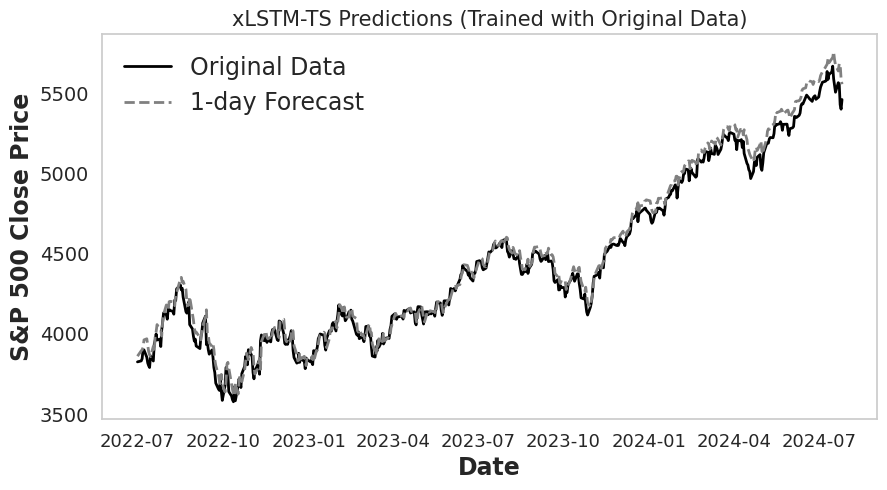

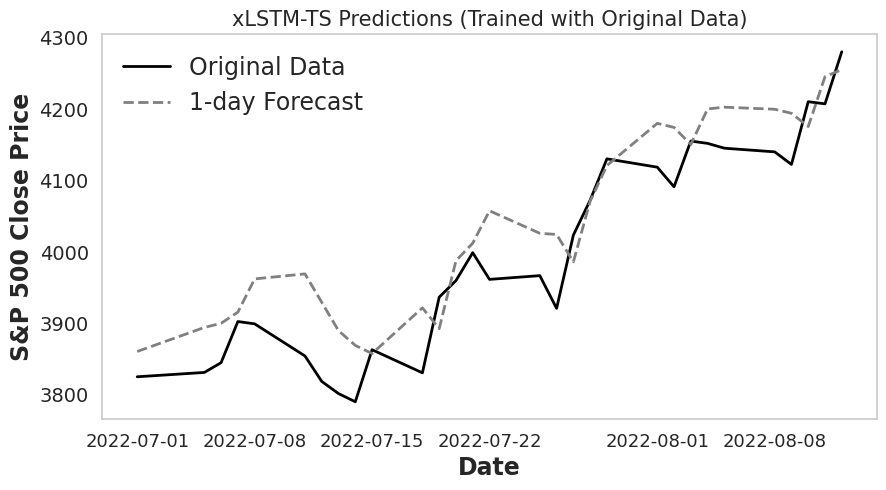

xLSTM-TS (Original) | Train Accuracy: 47.38%
xLSTM-TS (Original) | Validation Accuracy: 49.87%
xLSTM-TS (Original) | Test Accuracy: 50.29%
xLSTM-TS (Original) | Recall: 56.09%
xLSTM-TS (Original) | Precision (Rise): 52.23%
xLSTM-TS (Original) | Precision (Fall): 47.81%
xLSTM-TS (Original) | F1 Score: 54.09%


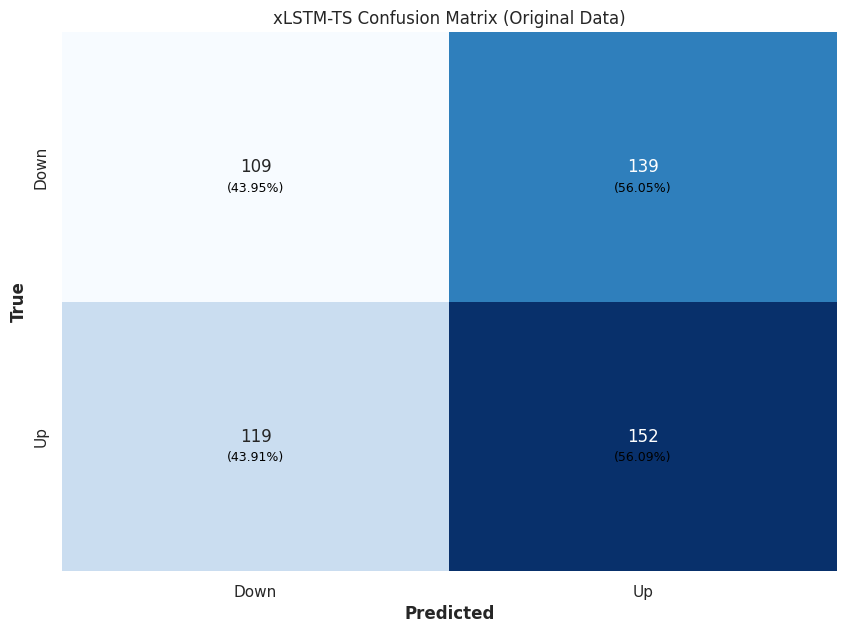

In [51]:
results_df, metrics = run_xlstm_ts(train_X, train_y, val_X, val_y, test_X, test_y, scaler, stock, 'Original', test_dates)

In [55]:
metrics_accumulator[model_name] = metrics

**Denoised**

Epoch [1/200], Loss: 0.00465557, Validation Loss: 0.01049444
Epoch [2/200], Loss: 0.00132575, Validation Loss: 0.00533395
Epoch [3/200], Loss: 0.00007344, Validation Loss: 0.00222019
Epoch [4/200], Loss: 0.00008454, Validation Loss: 0.00141169
Epoch [5/200], Loss: 0.00009556, Validation Loss: 0.00184257
Epoch [6/200], Loss: 0.00011473, Validation Loss: 0.00052667
Epoch [7/200], Loss: 0.00036837, Validation Loss: 0.00042685
Epoch [8/200], Loss: 0.00006852, Validation Loss: 0.00081086
Epoch [9/200], Loss: 0.00023982, Validation Loss: 0.00029046
Epoch [10/200], Loss: 0.00030008, Validation Loss: 0.00015291
Epoch [11/200], Loss: 0.00015574, Validation Loss: 0.00018617
Epoch [12/200], Loss: 0.00003448, Validation Loss: 0.00048225
Epoch [13/200], Loss: 0.00014151, Validation Loss: 0.00015074
Epoch [14/200], Loss: 0.00009818, Validation Loss: 0.00015116
Epoch [15/200], Loss: 0.00017770, Validation Loss: 0.00010912
Epoch [16/200], Loss: 0.00004880, Validation Loss: 0.00028864
Epoch [17/200], L

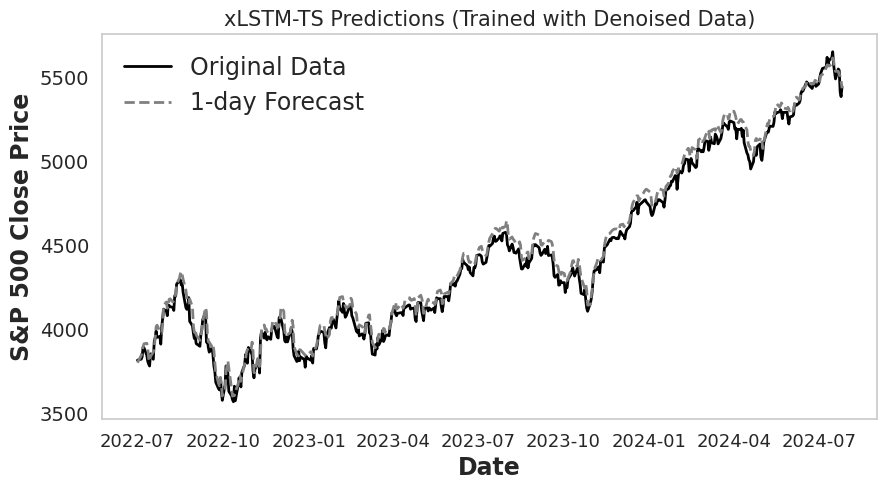

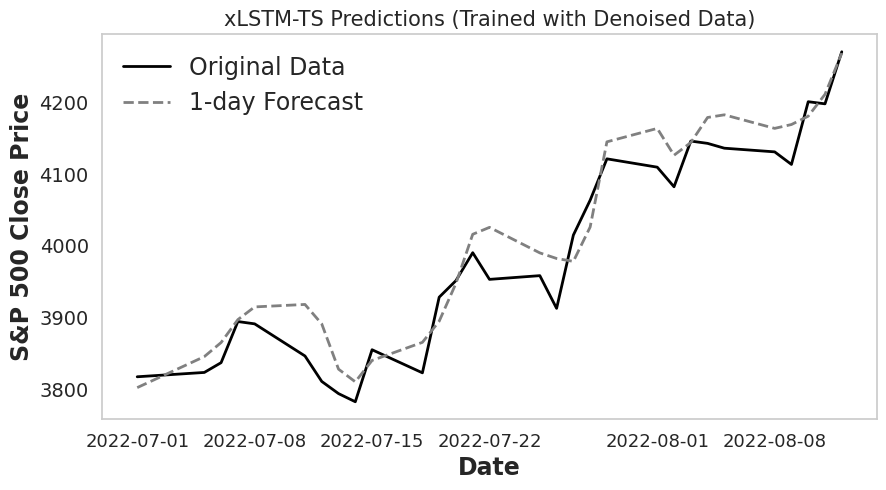

xLSTM-TS (Denoised) | Train Accuracy: 65.93%
xLSTM-TS (Denoised) | Validation Accuracy: 68.00%
xLSTM-TS (Denoised) | Test Accuracy: 64.93%
xLSTM-TS (Denoised) | Recall: 71.59%
xLSTM-TS (Denoised) | Precision (Rise): 64.88%
xLSTM-TS (Denoised) | Precision (Fall): 65.00%
xLSTM-TS (Denoised) | F1 Score: 68.07%


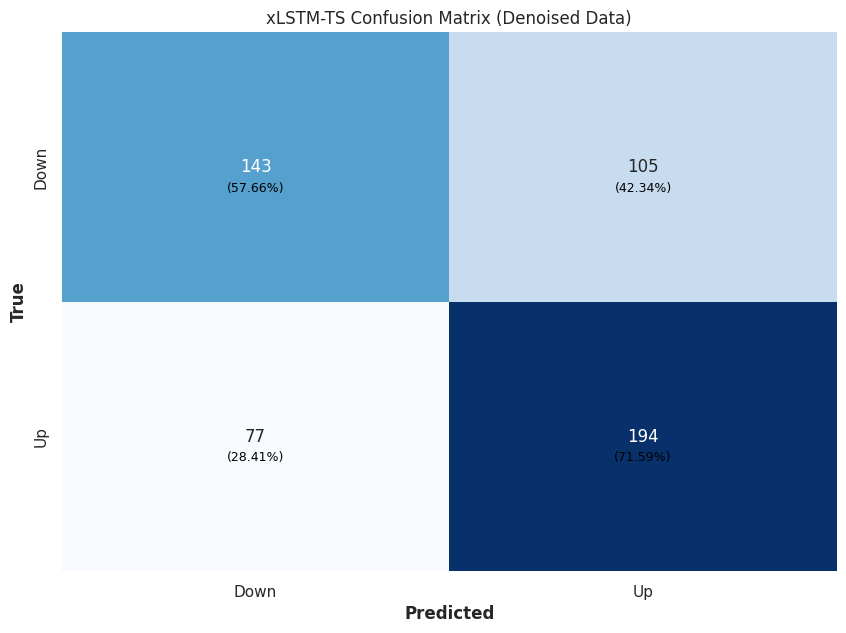

In [56]:
results_denoised_df, metrics_denoised = run_xlstm_ts(train_X_denoised, train_y_denoised, val_X_denoised, val_y_denoised, test_X_denoised, test_y, scaler_denoised, stock, 'Denoised', test_dates, train_y, val_y, test_y)

In [57]:
metrics_accumulator_denoised[model_name] = metrics_denoised

## Results

In [58]:
from ml.results.results import *

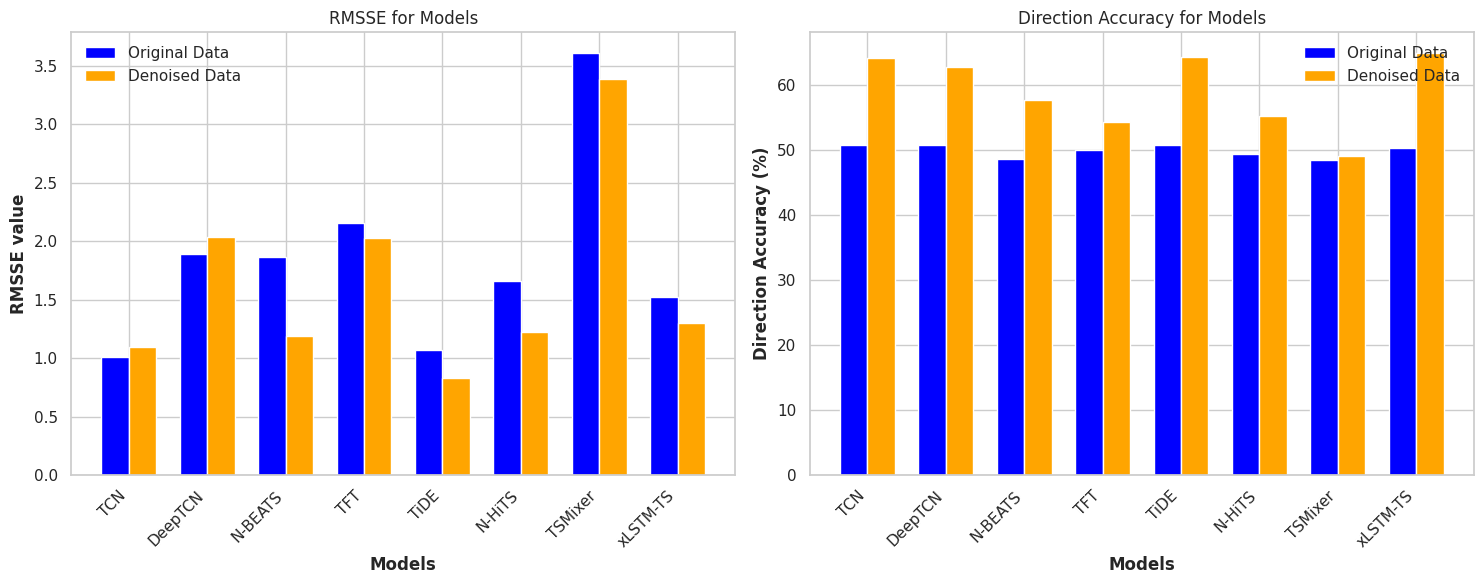

In [59]:
final_results = display_metrics(metrics_accumulator, metrics_accumulator_denoised)

In [60]:
original_data = show_results(final_results, 'Original')
denoised_data = show_results(final_results, 'Denoised')

In [61]:
original_data

MAE       MSE    RMSE  RMSSE   MAPE  MASE    R2 Test Accuracy  \
xLSTM-TS  50.73   4021.17   63.41   1.52  1.13%  1.60  0.99        50.29%   
TSMixer   94.58  17259.72  131.38   3.61  2.09%  3.33  0.93        48.45%   
N-HiTS    46.39   3648.80   60.41   1.66  1.03%  1.63  0.99        49.40%   
TiDE      30.91   1516.80   38.95   1.07  0.69%  1.09  0.99        50.84%   
TFT       55.93   6182.68   78.63   2.16  1.24%  1.97  0.98        50.12%   
N-BEATS   52.46   4621.72   67.98   1.87  1.16%  1.85  0.98        48.69%   
DeepTCN   59.08   4761.12   69.00   1.89  1.28%  2.08  0.98        50.84%   
TCN       29.01   1360.17   36.88   1.01  0.65%  1.02  0.99        50.84%   

          Recall Precision (Rise) Precision (Fall) F1 Score  \
xLSTM-TS  56.09%           52.23%           47.81%   54.09%   
TSMixer   50.22%           52.53%           44.06%   51.35%   
N-HiTS    51.10%           53.46%           45.05%   52.25%   
TiDE      54.63%           54.63%           46.35%   54.63%   
TFT       51.10%           54.21%           45.85%   52.61%   
N-BEATS   49.34%           52.83%           44.44%   51.03%   
DeepTCN   55.07%           54.59%           46.32%   54.82%   
TCN       55.51%           54.55%           46.28%   55.02%   

         Validation Accuracy Train Accuracy  
xLSTM-TS              49.87%         47.38%  
TSMixer               56.00%         48.91%  
N-HiTS                57.45%         48.68%  
TiDE                  53.82%         53.39%  
TFT                   59.27%         48.31%  
N-BEATS               57.82%         50.03%  
DeepTCN               50.55%         47.06%  
TCN                   49.09%         47.83%

In [62]:
denoised_data

MAE       MSE    RMSE  RMSSE   MAPE  MASE    R2 Test Accuracy  \
xLSTM-TS  45.66   2906.86   53.92   1.30  1.04%  1.44  0.99        64.93%   
TSMixer   88.92  15232.42  123.42   3.39  1.97%  3.13  0.94        49.16%   
N-HiTS    34.72   1999.87   44.72   1.23  0.77%  1.22  0.99        55.37%   
TiDE      24.01    921.82   30.36   0.83  0.53%  0.85  1.00        64.44%   
TFT       52.00   5437.44   73.74   2.02  1.15%  1.83  0.98        54.42%   
N-BEATS   32.70   1886.04   43.43   1.19  0.73%  1.15  0.99        57.76%   
DeepTCN   65.56   5503.36   74.18   2.04  1.42%  2.31  0.98        62.77%   
TCN       33.17   1587.29   39.84   1.09  0.72%  1.17  0.99        64.20%   

          Recall Precision (Rise) Precision (Fall) F1 Score  \
xLSTM-TS  71.59%           64.88%           65.00%   68.07%   
TSMixer   51.10%           53.21%           44.78%   52.13%   
N-HiTS    55.95%           59.35%           51.22%   57.60%   
TiDE      68.28%           66.81%           61.50%   67.54%   
TFT       55.07%           58.41%           50.24%   56.69%   
N-BEATS   60.79%           61.06%           53.89%   60.93%   
DeepTCN   70.93%           64.14%           60.71%   67.36%   
TCN       70.48%           65.84%           61.93%   68.09%   

         Validation Accuracy Train Accuracy  
xLSTM-TS              68.00%         65.93%  
TSMixer               56.36%         49.80%  
N-HiTS                64.36%         56.38%  
TiDE                  68.36%         67.55%  
TFT                   60.36%         51.90%  
N-BEATS               63.64%         58.56%  
DeepTCN               65.45%         64.65%  
TCN                   65.82%         64.23%

## Export

In [63]:
results_df.head(10)

Date        Close  Predicted Value  True Label  Predicted Label
0 2022-07-01  3825.330322      3860.712646           1                1
1 2022-07-05  3831.389893      3894.314453           1                1
2 2022-07-06  3845.080322      3900.167969           1                1
3 2022-07-07  3902.620117      3915.780273           0                1
4 2022-07-08  3899.379883      3962.291260           0                1
5 2022-07-11  3854.429932      3969.286377           0                0
6 2022-07-12  3818.800293      3929.497070           0                0
7 2022-07-13  3801.780029      3889.846924           0                0
8 2022-07-14  3790.379883      3869.229492           1                0
9 2022-07-15  3863.159912      3857.801514           0                1

In [64]:
results_denoised_df.head(10)

Date        Close  Predicted Value  True Label  Predicted Label
0 2022-07-01  3817.318604      3802.181641           1                1
1 2022-07-05  3823.363525      3845.478760           1                1
2 2022-07-06  3837.020508      3865.123047           1                1
3 2022-07-07  3894.419922      3897.096436           0                1
4 2022-07-08  3891.187744      3914.849609           0                1
5 2022-07-11  3846.347168      3918.281250           0                0
6 2022-07-12  3810.804443      3891.105225           0                0
7 2022-07-13  3793.825684      3827.969727           0                0
8 2022-07-14  3782.453369      3810.235596           1                1
9 2022-07-15  3855.056152      3840.137451           0                1

In [65]:
# -- Save predictions as CSV --

%cd ..

save_results(results_df, results_denoised_df, 'daily_sp500')

# -- Save the xLSTM-TS model --

# Rename the file
!mv xlstm-ts/best_model.pth xlstm_model_daily_sp500.pth

# Download if necessary

/content
